# Модель для определения температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. **Необходмо построить модель, которая предскажет температуру стали**.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Библиотеки

In [1]:
# импорты из стандартной библиотеки
import os
import math
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 



# импорты модулей текущего проекта
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost  import CatBoostRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor

# настройки
warnings.filterwarnings("ignore")

# константы 
RANDOM_STATE = 80523

PATH_ARC = '/datasets/data_arc_new.csv'
PATH_BULK = '/datasets/data_bulk_new.csv'
PATH_BULK_TIME = '/datasets/data_bulk_time_new.csv'
PATH_GAS = '/datasets/data_gas_new.csv'
PATH_TEMP = '/datasets/data_temp_new.csv'
PATH_WIRE = '/datasets/data_wire_new.csv'
PATH_WIRE_TIME = '/datasets/data_wire_time_new.csv'

## Разведывательный анализ данных

Определи вспомогательную функцию, которая будет выводить общую информацию о таблице, первые 10 строк таблицы, гистограмму и диаграмму размаха и статистическое описаине для количественных признаков, а также тепловую карту корреляции.

In [2]:
def exploring(data):
    
    print('Основная информация:')
    data.info()
    print('\n\n')
    
    print('Первые 10 строк таблицы:')
    display(data.head(10))
    print('\n\n')
    
    try:
        numeric_data = data.drop('key', axis=1).select_dtypes(include='number')
    except:
        numeric_data = data.select_dtypes(include='number')
    
    if len(numeric_data.columns) > 0:
        
        print('Графики для количественных признаков:')
        
        for i in range(numeric_data.shape[1]):
                
                fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                
                cur_column = numeric_data.columns[i]
                fig.suptitle(cur_column)
                cur_ax = axs[0]
                cur_ax.set_title('Гистограмма')
                cur_ax.set_xlabel('Значение')
                cur_ax.set_ylabel('Количество объектов')
                cur_ax.hist(numeric_data[cur_column])

                cur_ax = axs[1]
                cur_ax.set_title('Диаграмма размаха')
                cur_ax.set_ylabel('Значение')
                cur_ax.boxplot(numeric_data[cur_column].dropna(), labels=[cur_column])
                
                   
        plt.show()
        print('\n\n')
        
        print('Статистическое описание количественных признаков:')
        display(numeric_data.describe())
        print('\n\n')
        
        if len(numeric_data.columns) > 1:
            print('Тепловая карта корреляции между признаками:')
            size_y = max(5, len(numeric_data.columns) * 1)
            size_x = size_y + 0.4 * len(numeric_data.columns)
            fig, ax = plt.subplots(figsize=(size_x, size_y))
            sns.heatmap(numeric_data.corr().fillna(0), 
                        cmap=sns.color_palette("coolwarm", as_cmap=True),
                        vmin=-1, vmax=1,
                        annot=True,
                        fmt='.1f')
            ax.set_title('Корреляция')
            plt.show()
            print('\n\n')

Загрузим данные.

In [3]:
paths = [PATH_ARC,
         PATH_BULK,
         PATH_BULK_TIME,
         PATH_GAS,
         PATH_TEMP,
         PATH_WIRE,
         PATH_WIRE_TIME]
data_list = []

for i in range(len(paths)):
    if os.path.exists(paths[i]):
        try:
            data_list.append(pd.read_csv(paths[i]))
        except:
            print('Ошибка в считывании данных.')
    else:
        print(f'Путь {paths[i]} не сущесвтует.')

Все данные были успешно загружены.

Для удобства сформируем словарь полученных датафреймов.

In [4]:
names = ['Электроды',
         'Сыпучие материалы объем',
         'Сыпучие материалы время',
         'Газ',
         'Температура',
         'Проволока объем',
         'Проволока время']

data_dict = {names[i] : data_list[i] for i in range(len(data_list))}

In [5]:
data_dict.keys()

dict_keys(['Электроды', 'Сыпучие материалы объем', 'Сыпучие материалы время', 'Газ', 'Температура', 'Проволока объем', 'Проволока время'])

Словарь был успешно составлен.

Перейдём непосредственно к разведывательному анализу данных.

### Данные об электродах

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



Первые 10 строк таблицы:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856





Графики для количественных признаков:


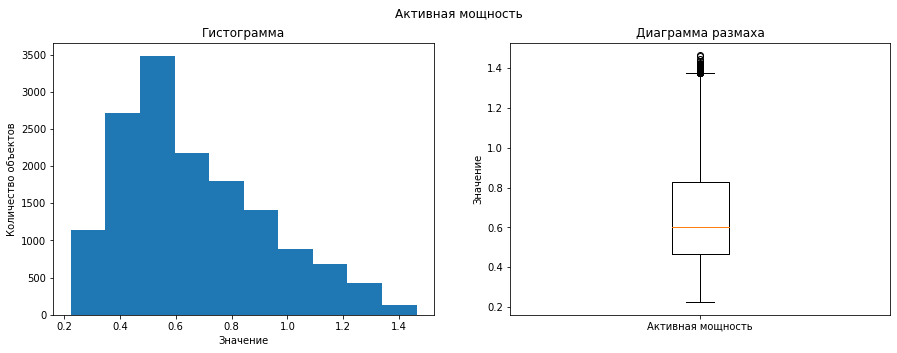

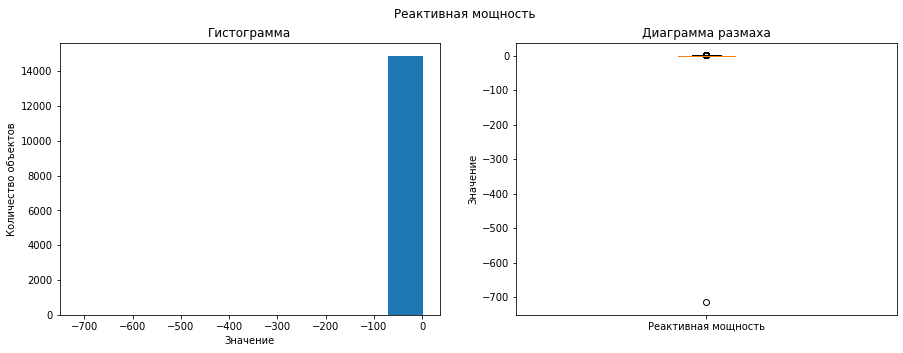




Статистическое описание количественных признаков:


,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284





Тепловая карта корреляции между признаками:


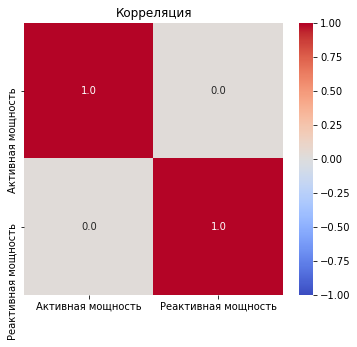

In [6]:
exploring(data_dict['Электроды'])

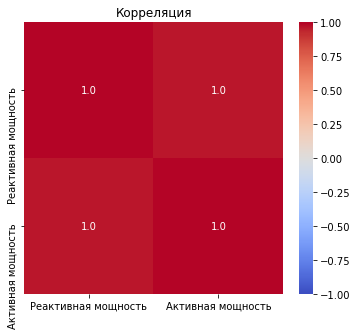

In [7]:
df = data_dict['Электроды'][['Реактивная мощность', 'Активная мощность']]
df = df[df['Реактивная мощность'] > 0]

size_y = max(5, len(df.columns) * 1)
size_x = size_y + 0.4 * len(df.columns)
fig, ax = plt.subplots(figsize=(size_x, size_y))
sns.heatmap(df.corr().fillna(0),
            cmap=sns.color_palette("coolwarm", as_cmap=True),
            vmin=-1, vmax=1,
            annot=True,
            fmt='.1f')
ax.set_title('Корреляция');

**Результаты анализа:**
    
1. в данных нет пропусков;
    
2. стобцы `Начало нагрева дугой` и `Конец нагрева дугой` содержат записи о времени, но представлены типом `object`; тип лучше заменить на `datetime` для удобства работы;
    
3. согласно графикам и статистическому описанию столбец `Реактивная мощность` имеет выбросы: есть значения около -700 при том, что значение мощности должно быть неотрицательным; партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
    
4. имеются аномально высокие значения, допускаемые бизнесом;
    
5. между `Активной` и `Реактивной мощность` обнаружена корреляция, близкая к 1;
    
6. на основе данных об электродах можно рассчиать суммарную затраченную энергию для каждой партии: $E = \sum\limits_{i=1}^n t_i P_i$, где $n$ - число нагревов партии, $P_i$ - полная мощность дла нагрева $i$, рассчитаная по формуле $P_i = \sqrt{P_{act \ i}^2 + P_{react \ i}^2}$, а $t_i$ рассчитывается как разница между началом и концом нагрева; сгенерированный признак будет использован для разработки модели.

### Данные о подаче сыпучих материалов (объем)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



Первые 10 строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0





Графики для количественных признаков:


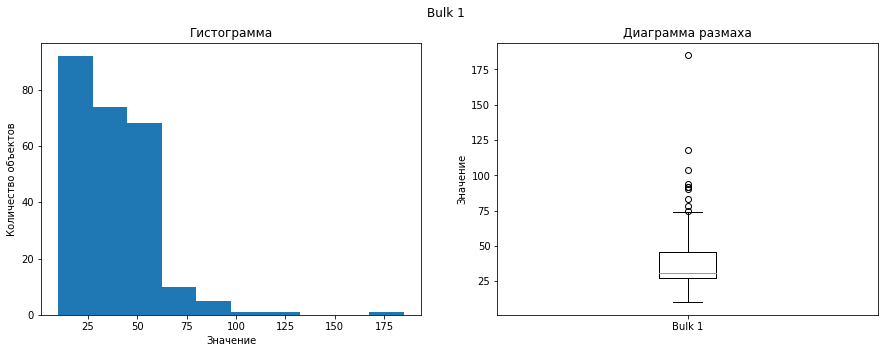

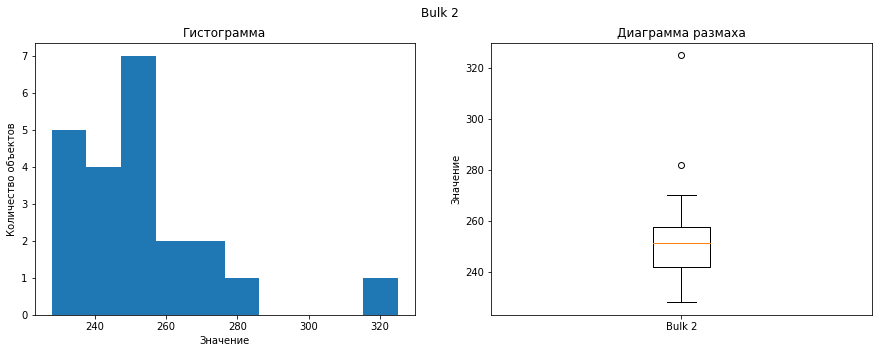

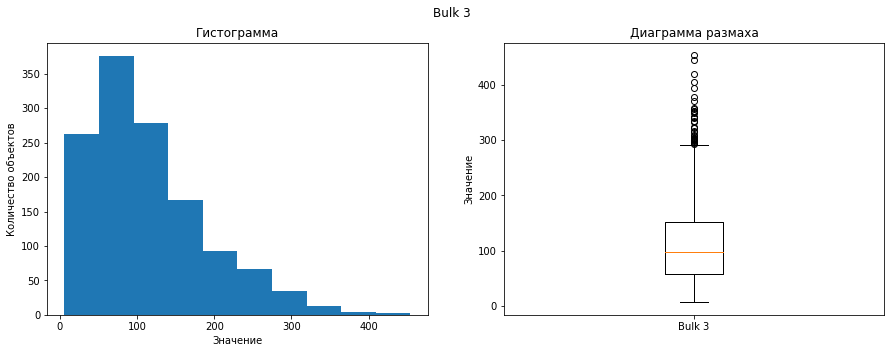

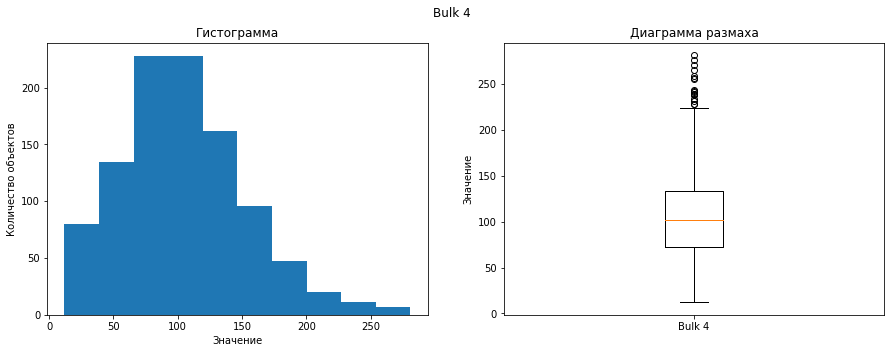

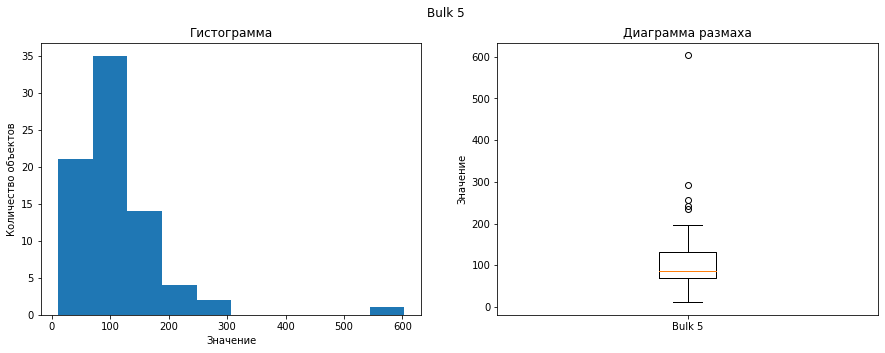

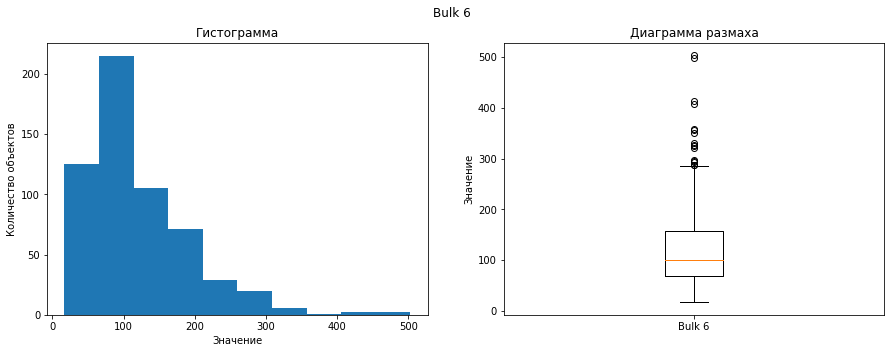

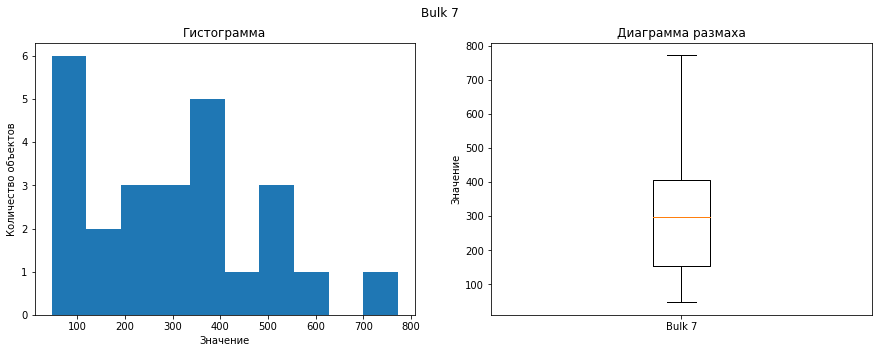

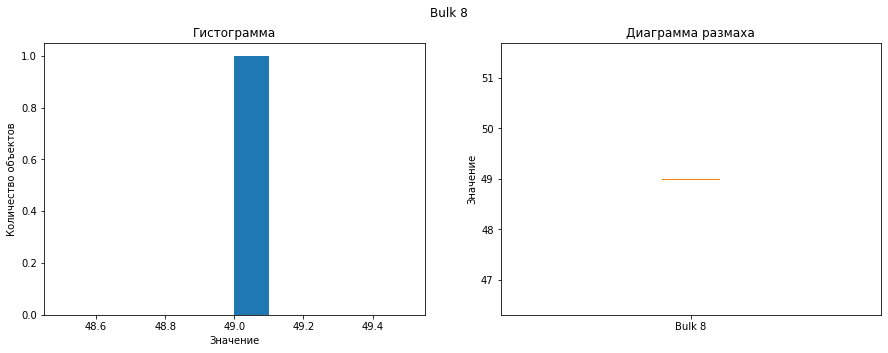

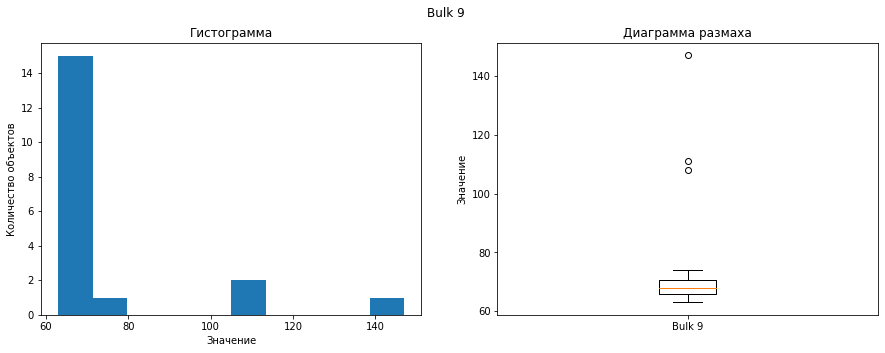

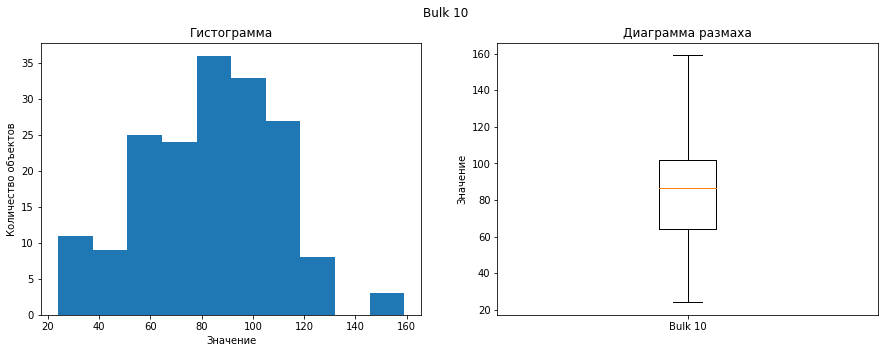

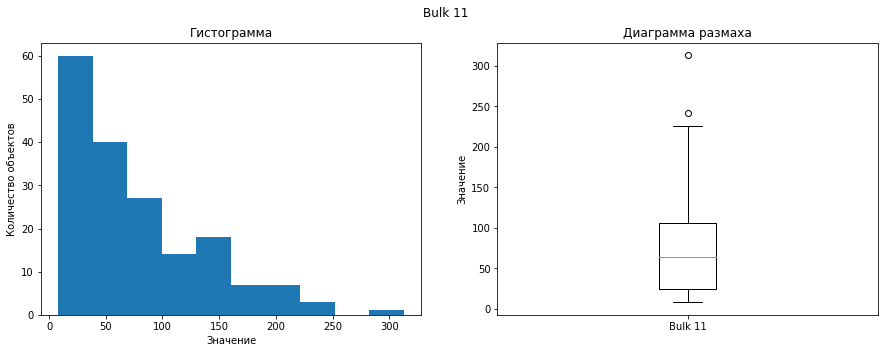

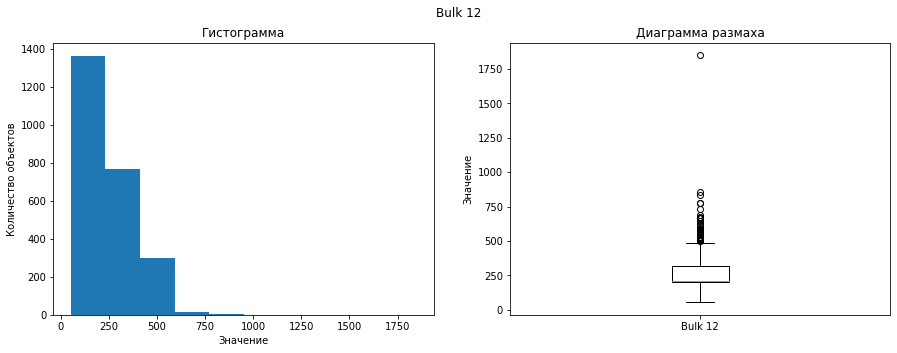

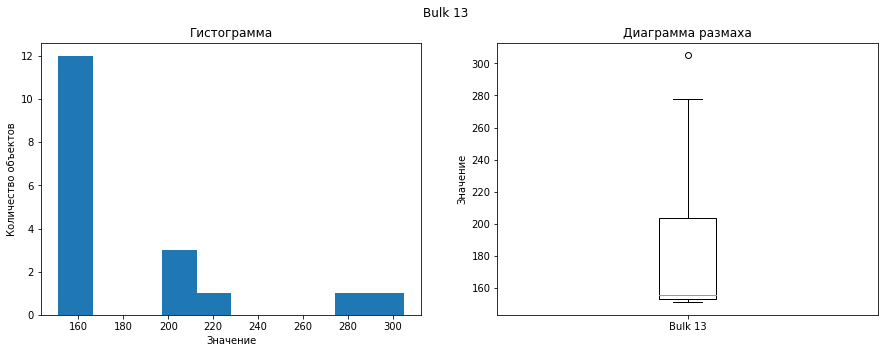

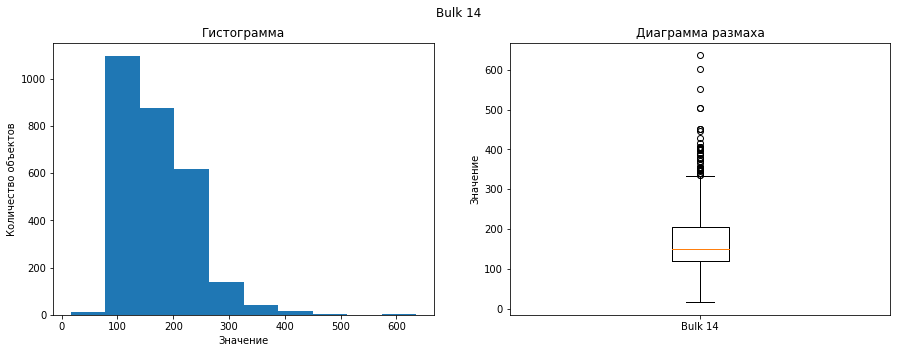

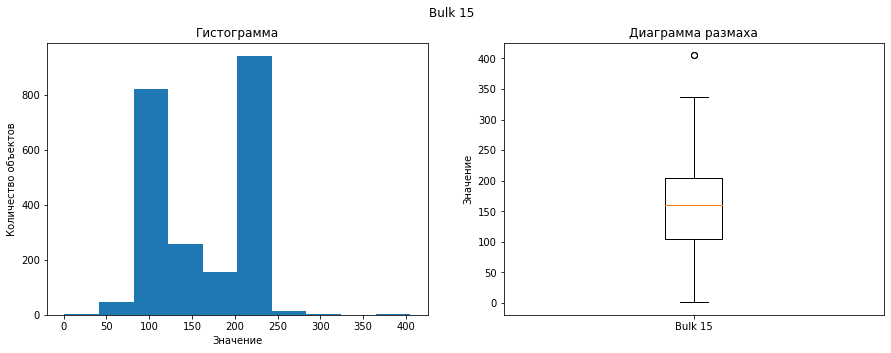




Статистическое описание количественных признаков:


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000





Тепловая карта корреляции между признаками:


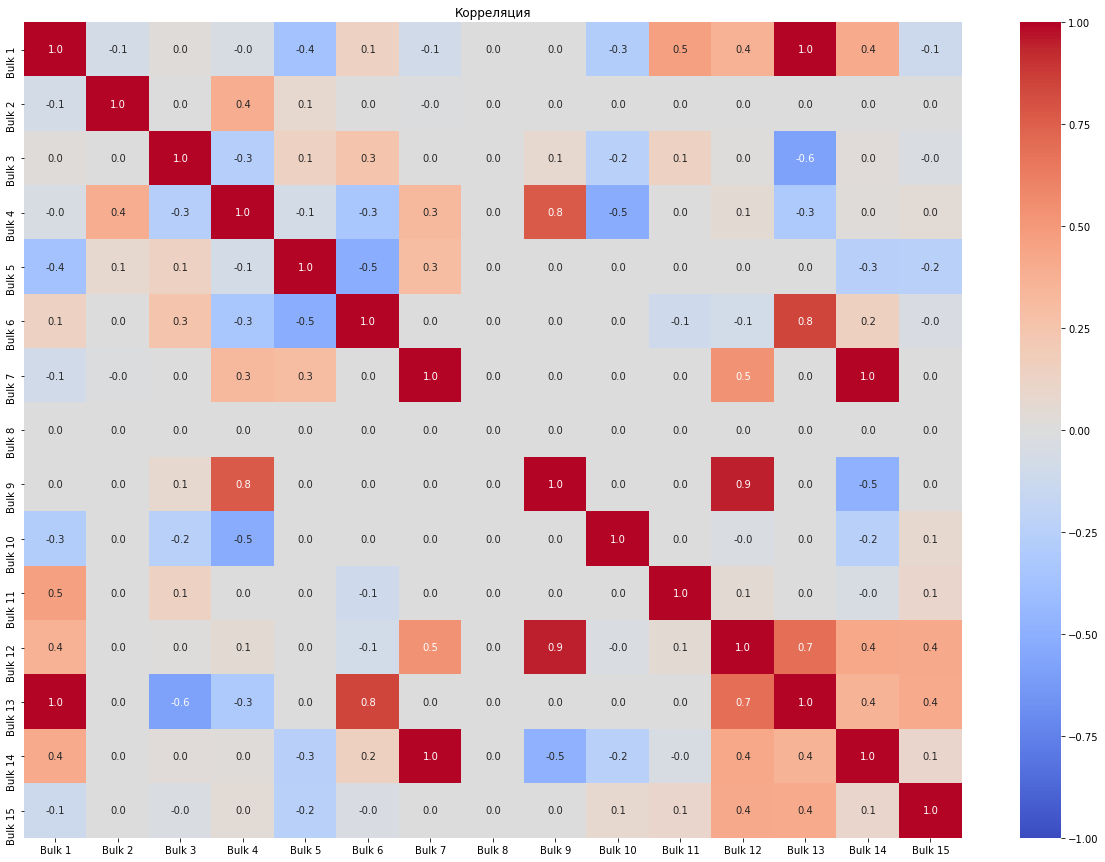

In [8]:
exploring(data_dict['Сыпучие материалы объем'])

**Результаты анализа:**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный сыпучий материал - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

### Данные о подаче сыпучих материалов (время)

In [9]:
exploring(data_dict['Сыпучие материалы время'])

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



Первые 10 строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


**Результаты анализа:**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

### Данные о продувке сплава газом

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB



Первые 10 строк таблицы:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891





Графики для количественных признаков:


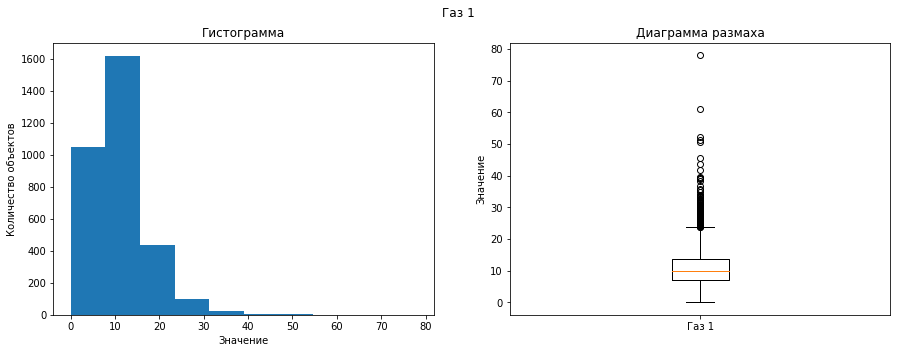




Статистическое описание количественных признаков:


,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


In [10]:
exploring(data_dict['Газ'])

**Результаты анализа:**
1. в данных нет пропусков; 
2. в признаках не обнаружено выбросов; присутствуют аномально высокие значения, допускаемые бизнесом.

### Результаты измерения температуры

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB



Первые 10 строк таблицы:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0





Графики для количественных признаков:


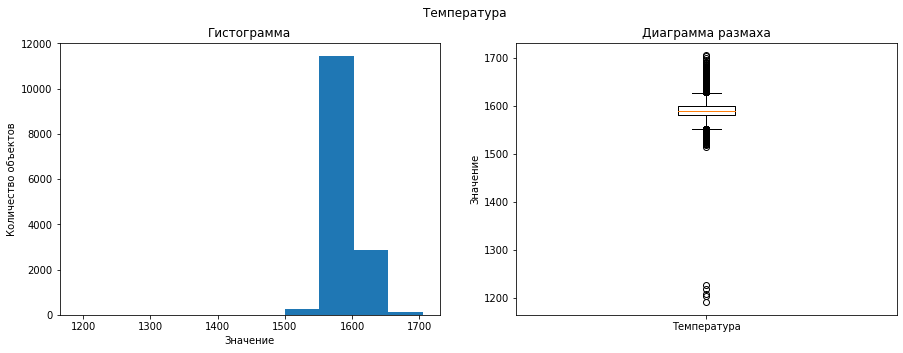




Статистическое описание количественных признаков:


,Температура
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


In [11]:
exploring(data_dict['Температура'])

**Результаты анализа:**
1. в данных много пропусков; можно поставить под сомнение адекватность замеров температуры для партий, в строках которых есть пропуски - такие партии лучше исключить из рассмотрения;  
2. в признаке `Температура` есть выбросы: некоторые значения меньше нижней грани температуры плавления стали (1300); партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
3. имеются как аномально высокие и аномально низкие значения, допускаемые бизнесом, так и аномально низкие значения, которые не допускаются (ниже 1450);
4. бизнес допускает использования в качестве признака первый замер температуры для партии; 
5. целевым признаком для модели является последний замер температуры в партии;
6. партии с единственным замером следует исключить из рассмотрения, иначе произойдёт утечка данных;
7. первый и последний замеры температуры в качестве разных признаков необходимо выделить в отдельный датафрейм.

### Данные о проволочных материалах (объём)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB



Первые 10 строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Графики для количественных признаков:


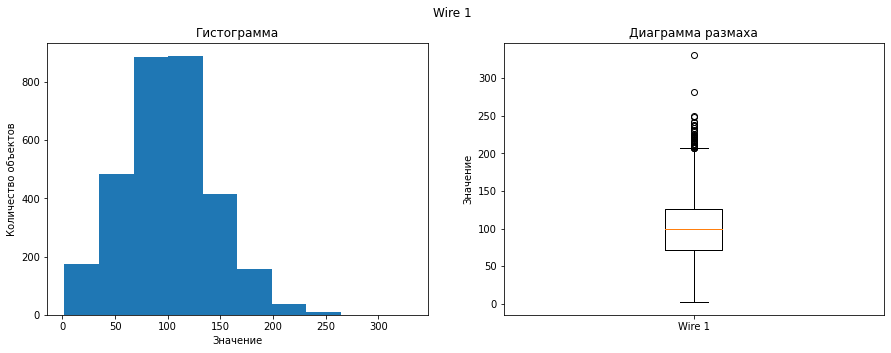

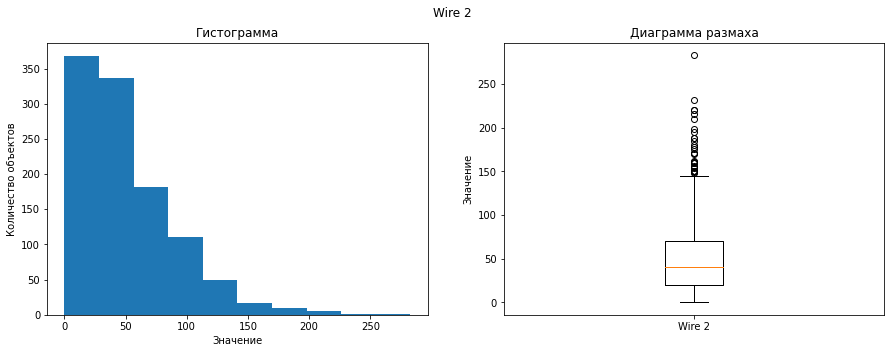

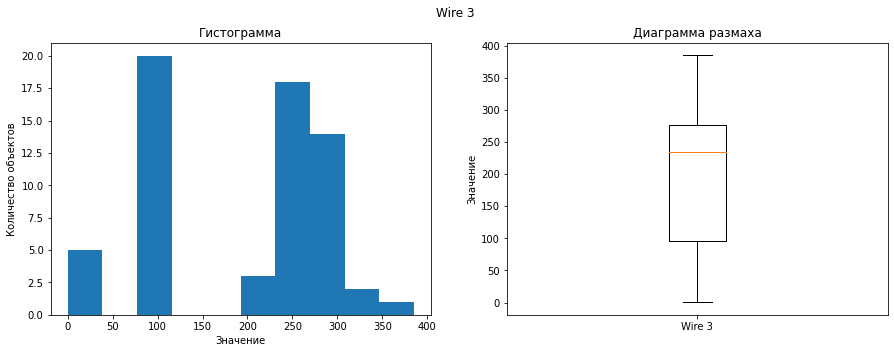

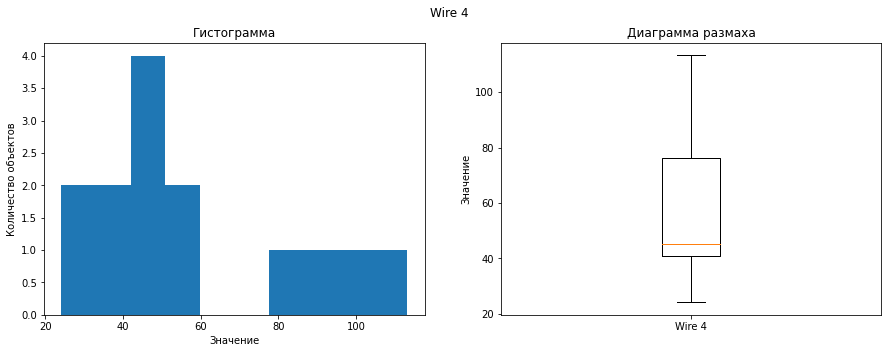

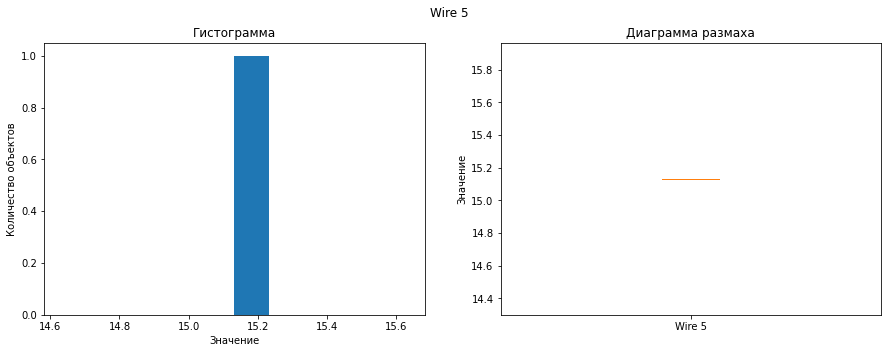

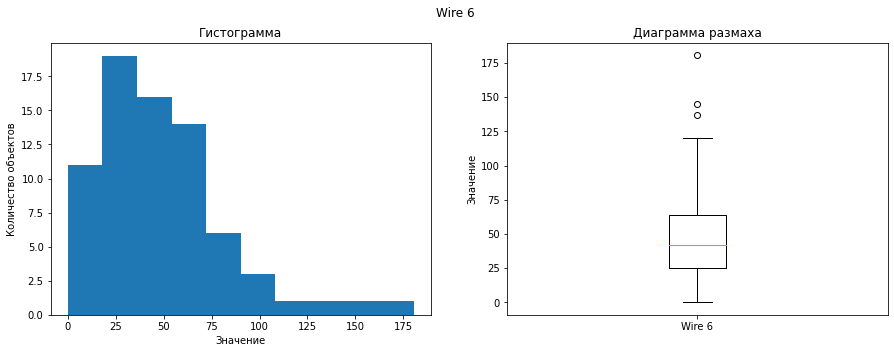

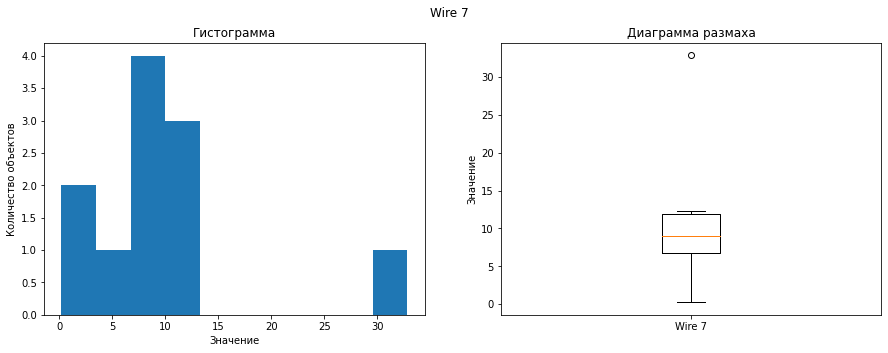

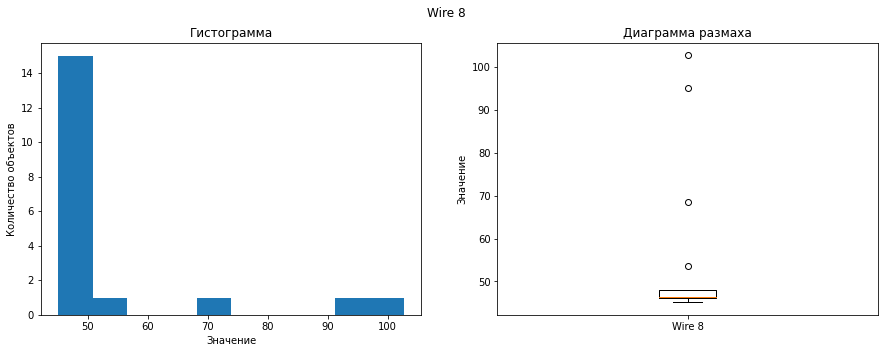

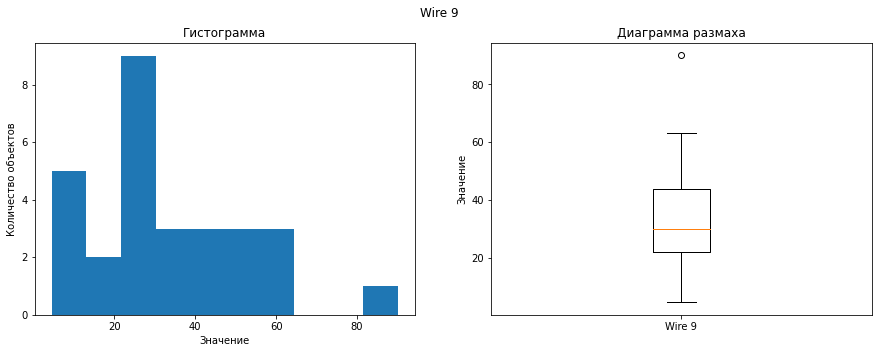




Статистическое описание количественных признаков:


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604





Тепловая карта корреляции между признаками:


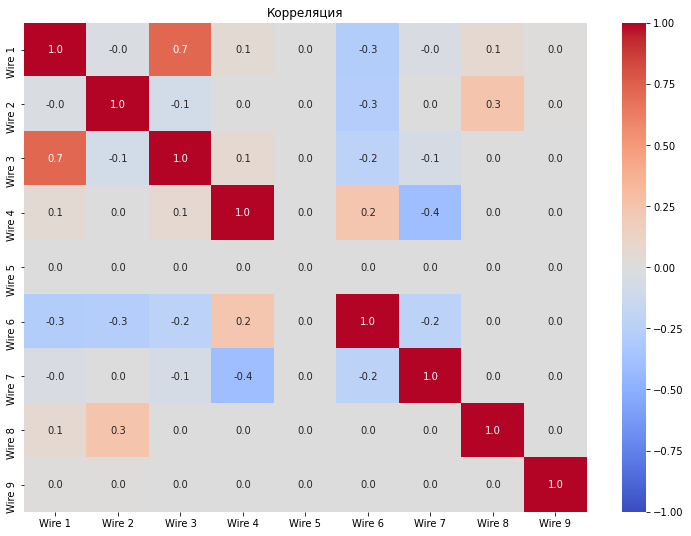

In [12]:
exploring(data_dict['Проволока объем'])

**Результаты анализа:**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный вид проволоки - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

### Данные о проволочных материалах (время)

In [13]:
exploring(data_dict['Проволока время'])

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



Первые 10 строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Результаты анализа:**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

### Вывод

На данном этапе для каждого набора данных был произведён разведывательный анализ.

**Результаты анализа данных об электродах:**
1. в данных нет пропусков;
2. стобцы `Начало нагрева дугой` и `Конец нагрева дугой` содержат записи о времени, но представлены типом `object`; тип лучше заменить на `datetime` для удобства работы;
3. согласно графикам и статистическому описанию столбец `Реактивная мощность` имеет выбросы: есть значения около -700 при том, что значение мощности должно быть неотрицательным; партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
4. имеются аномально высокие значения, допускаемые бизнесом;
5. между `Активной` и `Реактивной мощность` обнаружена корреляция, близкая к 1;
6. на основе данных об электродах можно рассчиать суммарную затраченную энергию для каждой партии: $E = \sum\limits_{i=1}^n t_i P_i$, где $n$ - число нагревов партии, $P_i$ - полная мощность дла нагрева $i$, рассчитаная по формуле $P_i = \sqrt{P_{act \ i}^2 + P_{react \ i}^2}$, а $t_i$ рассчитывается как разница между началом и концом нагрева; сгенерированный признак будет использован для разработки модели

**Результаты анализа данных о подаче сыпучих материалов (объем):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный сыпучий материал - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

**Результаты анализа данных о подаче сыпучих материалов (время):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

**Результаты анализа данных о продувке сплава газом:**
1. в данных нет пропусков; 
2. в признаках не обнаружено выбросов; присутствуют аномально высокие значения, допускаемые бизнесом.

**Результаты анализа данных об измерениях температуры:**
1. в данных много пропусков; можно поставить под сомнение адекватность замеров температуры для партий, в строках которых есть пропуски - такие партии лучше исключить из рассмотрения;  
2. в признаке `Температура` есть выбросы: некоторые значения меньше нижней грани температуры плавления стали (1300); партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
3. имеются как аномально высокие и аномально низкие значения, допускаемые бизнесом, так и аномально низкие значения, которые не допускаются (ниже 1450);
4. бизнес допускает использования в качестве признака первый замер температуры для партии; 
5. целевым признаком для модели является последний замер температуры в партии;
6. партии с единственным замером следует исключить из рассмотрения, иначе произойдёт утечка данных;
7. первый и последний замеры температуры в качестве разных признаков необходимо выделить в отдельный датафрейм.

**Результаты анализа данных о проволочных материалах (объем):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный вид проволоки - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

**Результаты анализа данных о проволочных материалах (время):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

## План работы

На основе разведывательного анализа данных можно составить следующий план работы.

1. **Предобработка данных**:
    1. Работа с данными:
        1. _Данные об электродах_:
            1. _Уаление партий с выбросами в признаке_ `Реактивная мощность`.
            2. _Замена типа_ `object` _на_ `datetime` _для колонок_ `Начало нагрева дугой` _и_ `Конец нагрева дугой`.
            3. _Генерация признака_ `Энергия` _с помощью агрегирования и рассчётов по имеющимся признакам_.
            4. _Удаление всех колонок, кроме_ `Key` _и_ `Энергия` _в связи с неинформативностью_.
        2. _Данные о подаче сыпучих материалов (объем)_:
            1. _Удаление неинформативных колонок_.
            2. _Заполнение пропусков нулями_.
        3. _Результаты измерения температуры_:
            1. _Удаление всех колонок, кроме_ `Key` _и_ `Температура`_в связи с неинформативностью_.
            2. _Удаление партий, для которых есть пропуски_.
            3. _Удаление партий с выбросами в признаке_ `Температура`.
            4. _Удаление партий с единственным замером температуры_.
            5. _Выделение данных в новый датафрейм с колонками_ `Key`,`Начальная температура` _и_ `Финальная температура`.
        2. _Данные о проволочных материалах (объем)_:
            1. _Удаление неинформативных колонок_.
            2. _Заполнение пропусков нулями_.
    2. Внутреннее объединение (inner_join) вышеперечисленных данных и данных о продувке сплавов по стобцу `Key`; удаление столбца `Key` в связи с неинформативностью.
    3. Исследование признаков в нового датафрейма:
        1. Графический и статистический анализ.
        2. Анализ корреляции признаков.
    4. Написание вывода по этапу.
2. **Обучение моделей**:
    1. Подготовка признаков: 
        1. _Разделение данных на признаки и целевой признак_.
        2. _Разбиение признаков на обучающую и тестовую выборки_.
    2. Выбор моделей (предположительно LinearRegression, RandomForestRegressor и CatBoostRegressor).
    3. Формирование пайплайна:
        1. _Создание обработчиков и селекторов колонок_.
        2. _Создание пайплайнов из обработчиков, селекторов и моделей_.
        3. _Поиск оптимальных параметров и лучших моделей с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE_.
    4. Выбор лучшей модели для рекомендации.
    5. Анализ важности признаков для рекомендуемой модели.
    5. Написание вывода по этапу.
3. **Тестирование рекомендуемой модели**:
    1. Оценка качества на тестовой выборке с помощью метрики MAE.
    2. Проверка модели на адекватность: сравнение с константной моделью.
    3. Написание вывода по этапу.
4. **Написание общего вывода о проделанной работе**.

## Предобработка данных

### Работа с данными

#### Данные об электродах

Удалим из данных партии с выбросами в признаке `Реактивная мощность`.

,количество строк,количество партий
до удаления,14876,3214
для удаления,4,1
после удаления,14872,3213


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


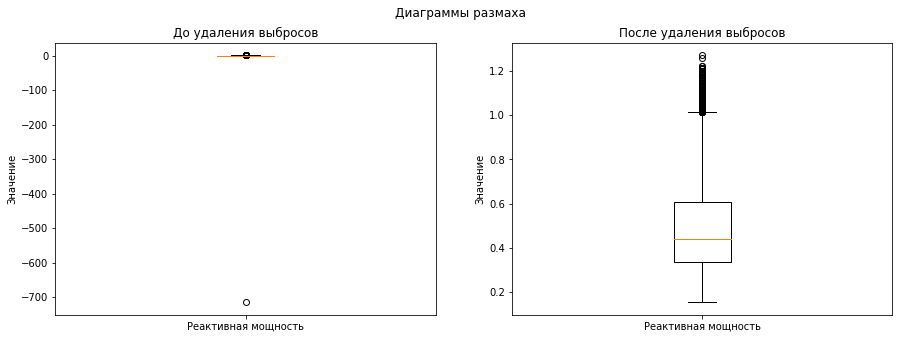

In [14]:
energy_data = data_dict['Электроды'].copy()
columns = ['количество строк', 'количество партий']
indices = ['до удаления', 'для удаления', 'после удаления']
removing_keys = energy_data.loc[energy_data['Реактивная мощность'] < 0, 'key'].unique()
before_del = [energy_data.shape[0], len(data_dict['Электроды']['key'].unique())]
for_del = [energy_data[energy_data['key'].isin(removing_keys)].shape[0], len(removing_keys)]
energy_data = energy_data[~energy_data['key'].isin(removing_keys)]
after_del = [energy_data.shape[0], len(energy_data['key'].unique())]

data_info = pd.DataFrame({columns[i]:[before_del[i], for_del[i], after_del[i]] for i in range(len(columns))},
                        index=indices)
display(data_info)

display(energy_data.head(10))



fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                
fig.suptitle('Диаграммы размаха')

cur_ax = axs[0]
cur_ax.set_title('До удаления выбросов')
cur_ax.set_ylabel('Значение')
cur_ax.boxplot(data_dict['Электроды']['Реактивная мощность'], labels=['Реактивная мощность'])
                                                                      
cur_ax = axs[1]
cur_ax.set_title('После удаления выбросов')
cur_ax.set_ylabel('Значение')
cur_ax.boxplot(energy_data['Реактивная мощность'], labels=['Реактивная мощность'])
plt.show()

Партии с выбросами успешно удалены.

Изменим тип колонок `Начало нагрева дугой` и `Конец нагрева дугой` с `object` на `datetime`.

In [15]:
energy_data['Начало нагрева дугой'] = pd.to_datetime(energy_data['Начало нагрева дугой'])
energy_data['Конец нагрева дугой'] = pd.to_datetime(energy_data['Конец нагрева дугой'])
display(energy_data.head(10))
energy_data.info();

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


Типы успешно изменены.

Сгенерируем признак `Энергия`. Для этого  напишем вспомогательные функции.

In [16]:
def calc_energy_row(row):
    P = (row['Активная мощность'] ** 2 + row['Реактивная мощность'] ** 2) ** 0.5
    t = (row['Конец нагрева дугой'] - row['Начало нагрева дугой']).total_seconds()
    return P * t

In [17]:
def calc_energy(energy_data):
    energy_data_c = energy_data.copy()
    energy_data_c['Энергия'] = energy_data_c.apply(calc_energy_row, axis=1)
    final_energy_data = energy_data_c[['key', 'Энергия']]
    final_energy_data = final_energy_data.groupby('key', as_index=False).agg(sum)
    return final_energy_data

Посчитаем энергию для каждой партии.

In [18]:
final_energy_data = calc_energy(energy_data)
final_energy_data.head(10)

,key,Энергия
0,1,770.282114
1,2,481.760005
2,3,722.837668
3,4,683.455597
4,5,512.169934
5,6,839.231310
6,7,613.576982
7,8,619.129542
8,9,570.113675
9,10,533.482050


Энергия успешно посчитана, а неинофрмативные столбцы сброшены.

In [19]:
final_data_list = [final_energy_data]

#### Данные о подаче сыпучих материалов (объем)

Будем считать неинформативными колонки, в которых не пусто более 95% значений. Удалим такие колонки.

In [20]:
threshold = round(data_dict['Сыпучие материалы объем'].shape[0] * 0.05)
inf_columns = []
for column in data_dict['Сыпучие материалы объем'].columns:
    if data_dict['Сыпучие материалы объем'][column].notna().sum() > threshold:
        inf_columns.append(column)    

print('Данные до удаления неинформативных колонок:')

display(data_dict['Сыпучие материалы объем'].head(10))
data_dict['Сыпучие материалы объем'].info()

print(f'\nПорог вхождения: {threshold} непустых значений.')
bulk_data = data_dict['Сыпучие материалы объем'][inf_columns].copy()

print('Данные после удаления неинформативных колонок:')
display(bulk_data.head(10))
bulk_data.info()

Данные до удаления неинформативных колонок:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Порог вхождения: 156 непустых значений.
Данные после удаления неинформативных колонок:


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,NaN,43.0,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,73.0,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,34.0,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,81.0,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,78.0,NaN,NaN,NaN,203.0,151.0,152.0
5,6,NaN,NaN,117.0,NaN,NaN,NaN,204.0,201.0,154.0
6,7,NaN,NaN,117.0,NaN,NaN,NaN,204.0,152.0,154.0
7,8,NaN,NaN,99.0,NaN,NaN,NaN,410.0,252.0,153.0
8,9,NaN,NaN,117.0,NaN,NaN,NaN,107.0,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,203.0,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 6   576 non-null    float64
 5   Bulk 10  176 non-null    float64
 6   Bulk 11  177 non-null    float64
 7   Bulk 12  2450 non-null   float64
 8   Bulk 14  2806 non-null   float64
 9   Bulk 15  2248 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 244.6 KB


Заполним пропуски нулями.

In [21]:
final_bulk_data = bulk_data.fillna(0)
final_bulk_data.head(10)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0
5,6,0.0,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0
6,7,0.0,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0
7,8,0.0,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0
8,9,0.0,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,203.0,102.0,204.0


Пропуски успешно заполнены.

In [22]:
final_data_list.append(final_bulk_data)

#### Результаты измерения температуры

Выберем для работы только информативные колонки `key` и `Температура`. Удалим из данных партии, для которых есть пропуски, выбросы или значения, не допускаемы бизнесом: температура меньше 1450.

,количество строк,количество партий
до удаления,18092,3216
для удаления,4187,743
после удаления,13905,2473


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13905 non-null  int64  
 1   Температура  13905 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 325.9 KB


,key,Температура
0,1,1571.0
1,1,1604.0
2,1,1618.0
3,1,1601.0
4,1,1606.0
5,1,1613.0
6,2,1581.0
7,2,1577.0
8,2,1589.0
9,2,1604.0


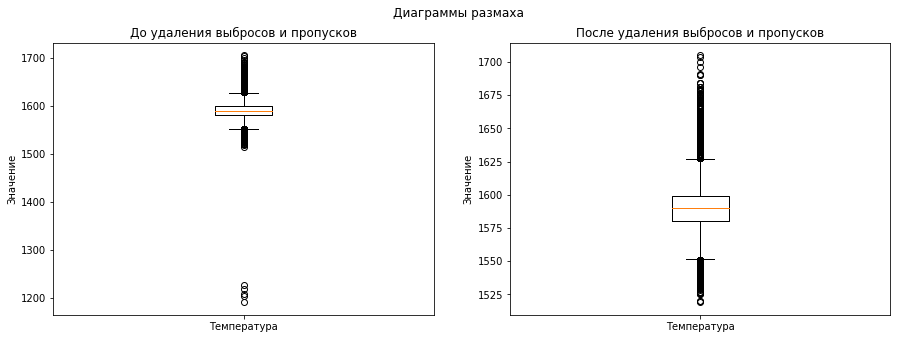

In [23]:
temp_data = data_dict['Температура'][['key', 'Температура']].copy()

columns = ['количество строк', 'количество партий']
indices = ['до удаления', 'для удаления', 'после удаления']
removing_keys = temp_data.loc[(temp_data['Температура'] < 1450) \
                                | (temp_data['Температура'].isna()), 'key'].unique()
before_del = [temp_data.shape[0], len(data_dict['Температура']['key'].unique())]
for_del = [temp_data[temp_data['key'].isin(removing_keys)].shape[0], len(removing_keys)]
temp_data = temp_data[~temp_data['key'].isin(removing_keys)]
after_del = [temp_data.shape[0], len(temp_data['key'].unique())]

data_info = pd.DataFrame({columns[i]:[before_del[i], for_del[i], after_del[i]] for i in range(len(columns))},
                        index=indices)
display(data_info)
temp_data.info()
display(temp_data.head(10))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
                
fig.suptitle('Диаграммы размаха')

cur_ax = axs[0]
cur_ax.set_title('До удаления выбросов и пропусков')
cur_ax.set_ylabel('Значение')
cur_ax.boxplot(data_dict['Температура']['Температура'].dropna(), labels=['Температура'])
                                                                      
cur_ax = axs[1]
cur_ax.set_title('После удаления выбросов и пропусков')
cur_ax.set_ylabel('Значение')
cur_ax.boxplot(temp_data['Температура'], labels=['Температура'])
plt.show()

Партии успешно удалены.

Удалим партии с единственным замером температуры.

In [24]:
temp_data_v2 = temp_data.copy()
columns = ['количество строк', 'количество партий']
indices = ['до удаления', 'для удаления', 'после удаления']
removing_keys = (~temp_data_v2['key'].duplicated(keep=False)).sum()
before_del = [temp_data_v2.shape[0], len(temp_data_v2['key'].unique())]
for_del = [temp_data_v2[~temp_data_v2['key'].duplicated(keep=False)].shape[0], removing_keys]
temp_data_v2 = temp_data_v2[temp_data_v2['key'].duplicated(keep=False)]
after_del = [temp_data_v2.shape[0], len(temp_data_v2['key'].unique())]

data_info = pd.DataFrame({columns[i]:[before_del[i], for_del[i], after_del[i]] for i in range(len(columns))},
                        index=indices)
display(data_info)
temp_data_v2.info()

,количество строк,количество партий
до удаления,13905,2473
для удаления,2,2
после удаления,13903,2471


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          13903 non-null  int64  
 1   Температура  13903 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 325.9 KB


Партии с одним замером температуры успешно удалены.

Для последующей работы создадим новый датафрейм с колонками `key`,`Начальная температура` и `Финальная температура`.

In [25]:
final_temp_data = pd.DataFrame()
final_temp_data[['key', 'Начальная температура']] = temp_data_v2.drop_duplicates('key', keep='first')
final_temp_data['Финальная температура'] = temp_data_v2.drop_duplicates('key', keep='last').set_index(final_temp_data.index)['Температура']
final_temp_data.info()
final_temp_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 13921
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2471 non-null   int64  
 1   Начальная температура  2471 non-null   float64
 2   Финальная температура  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


,key,Начальная температура,Финальная температура
0,1,1571.0,1613.0
6,2,1581.0,1602.0
11,3,1596.0,1599.0
17,4,1601.0,1625.0
22,5,1576.0,1602.0
27,6,1543.0,1596.0
32,7,1586.0,1599.0
37,8,1577.0,1598.0
42,9,1587.0,1592.0
48,10,1574.0,1593.0


Датафрейм успешно создан.

In [26]:
final_data_list.append(final_temp_data)

#### Данные о проволочных материалах (объем)

Удалим неинформативные колонки по тому же принципу, что в данных о подаче сыпучих материалов (объем), взяв прежний порог вхождения, т.к. данных о подаче сыпучих материалов больше, чем данных о проволочных.

In [27]:
inf_columns = []
for column in data_dict['Проволока объем'].columns:
    if data_dict['Проволока объем'][column].notna().sum() > threshold:
        inf_columns.append(column)    

print('Данные до удаления неинформативных колонок:')

display(data_dict['Проволока объем'].head(10))
data_dict['Проволока объем'].info()

print(f'\nПорог вхождения: {threshold} непустых значений.')
wire_data = data_dict['Проволока объем'][inf_columns].copy()

print('Данные после удаления неинформативных колонок:')
display(wire_data.head(10))
wire_data.info()

Данные до удаления неинформативных колонок:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Порог вхождения: 156 непустых значений.
Данные после удаления неинформативных колонок:


,key,Wire 1,Wire 2
0,1,60.059998,NaN
1,2,96.052315,NaN
2,3,91.160157,NaN
3,4,89.063515,NaN
4,5,89.238236,9.114560
5,6,99.109917,9.114560
6,7,98.061600,NaN
7,8,155.282394,NaN
8,9,113.393279,9.143681
9,10,81.244796,12.376000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


Заполним пропуски нулями.

In [28]:
final_wire_data = wire_data.fillna(0)
final_wire_data.head(10)

,key,Wire 1,Wire 2
0,1,60.059998,0.000000
1,2,96.052315,0.000000
2,3,91.160157,0.000000
3,4,89.063515,0.000000
4,5,89.238236,9.114560
5,6,99.109917,9.114560
6,7,98.061600,0.000000
7,8,155.282394,0.000000
8,9,113.393279,9.143681
9,10,81.244796,12.376000


Пропуски успешно заполнены.

In [29]:
final_data_list.append(final_wire_data)

### Слияние данных в итоговый датафрейм

Для слияния воспользуемся методом `join` с параметром `how=inner`.

In [30]:
final_data = data_dict['Газ'].set_index('key')
for data in final_data_list:
    final_data = final_data.join(data.set_index('key'), how='inner')
final_data.info()
final_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Газ 1                  2324 non-null   float64
 1   Энергия                2324 non-null   float64
 2   Bulk 1                 2324 non-null   float64
 3   Bulk 3                 2324 non-null   float64
 4   Bulk 4                 2324 non-null   float64
 5   Bulk 6                 2324 non-null   float64
 6   Bulk 10                2324 non-null   float64
 7   Bulk 11                2324 non-null   float64
 8   Bulk 12                2324 non-null   float64
 9   Bulk 14                2324 non-null   float64
 10  Bulk 15                2324 non-null   float64
 11  Начальная температура  2324 non-null   float64
 12  Финальная температура  2324 non-null   float64
 13  Wire 1                 2324 non-null   float64
 14  Wire 2                 2324 non-null   float64
dtypes: f

,Газ 1,Энергия,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Начальная температура,Финальная температура,Wire 1,Wire 2
key,,,,,,,,,,,,,,,
1,29.749986,770.282114,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,1613.0,60.059998,0.000000
2,12.555561,481.760005,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,1602.0,96.052315,0.000000
3,28.554793,722.837668,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,1599.0,91.160157,0.000000
4,18.841219,683.455597,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,1625.0,89.063515,0.000000
5,5.413692,512.169934,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,1602.0,89.238236,9.114560
6,11.273392,839.231310,0.0,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0,1543.0,1596.0,99.109917,9.114560
7,9.836267,613.576982,0.0,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0,1586.0,1599.0,98.061600,0.000000
8,15.171553,619.129542,0.0,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0,1577.0,1598.0,155.282394,0.000000
9,8.216623,570.113675,0.0,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0,1587.0,1592.0,113.393279,9.143681


In [31]:
final_data.head(10)

,Газ 1,Энергия,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Начальная температура,Финальная температура,Wire 1,Wire 2
key,,,,,,,,,,,,,,,
1,29.749986,770.282114,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,1613.0,60.059998,0.000000
2,12.555561,481.760005,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,1602.0,96.052315,0.000000
3,28.554793,722.837668,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,1599.0,91.160157,0.000000
4,18.841219,683.455597,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,1625.0,89.063515,0.000000
5,5.413692,512.169934,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,1602.0,89.238236,9.114560
6,11.273392,839.231310,0.0,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0,1543.0,1596.0,99.109917,9.114560
7,9.836267,613.576982,0.0,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0,1586.0,1599.0,98.061600,0.000000
8,15.171553,619.129542,0.0,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0,1577.0,1598.0,155.282394,0.000000
9,8.216623,570.113675,0.0,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0,1587.0,1592.0,113.393279,9.143681


### Исследование признаков нового датафрейма

Основная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 1 to 2499
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Газ 1                  2324 non-null   float64
 1   Энергия                2324 non-null   float64
 2   Bulk 1                 2324 non-null   float64
 3   Bulk 3                 2324 non-null   float64
 4   Bulk 4                 2324 non-null   float64
 5   Bulk 6                 2324 non-null   float64
 6   Bulk 10                2324 non-null   float64
 7   Bulk 11                2324 non-null   float64
 8   Bulk 12                2324 non-null   float64
 9   Bulk 14                2324 non-null   float64
 10  Bulk 15                2324 non-null   float64
 11  Начальная температура  2324 non-null   float64
 12  Финальная температура  2324 non-null   float64
 13  Wire 1                 2324 non-null   float64
 14  Wire 2                 2324 non-nul

,Газ 1,Энергия,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Начальная температура,Финальная температура,Wire 1,Wire 2
key,,,,,,,,,,,,,,,
1,29.749986,770.282114,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,1571.0,1613.0,60.059998,0.000000
2,12.555561,481.760005,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,1581.0,1602.0,96.052315,0.000000
3,28.554793,722.837668,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,1596.0,1599.0,91.160157,0.000000
4,18.841219,683.455597,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,1601.0,1625.0,89.063515,0.000000
5,5.413692,512.169934,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,1576.0,1602.0,89.238236,9.114560
6,11.273392,839.231310,0.0,0.0,117.0,0.0,0.0,0.0,204.0,201.0,154.0,1543.0,1596.0,99.109917,9.114560
7,9.836267,613.576982,0.0,0.0,117.0,0.0,0.0,0.0,204.0,152.0,154.0,1586.0,1599.0,98.061600,0.000000
8,15.171553,619.129542,0.0,0.0,99.0,0.0,0.0,0.0,410.0,252.0,153.0,1577.0,1598.0,155.282394,0.000000
9,8.216623,570.113675,0.0,0.0,117.0,0.0,0.0,0.0,107.0,99.0,203.0,1587.0,1592.0,113.393279,9.143681





Графики для количественных признаков:


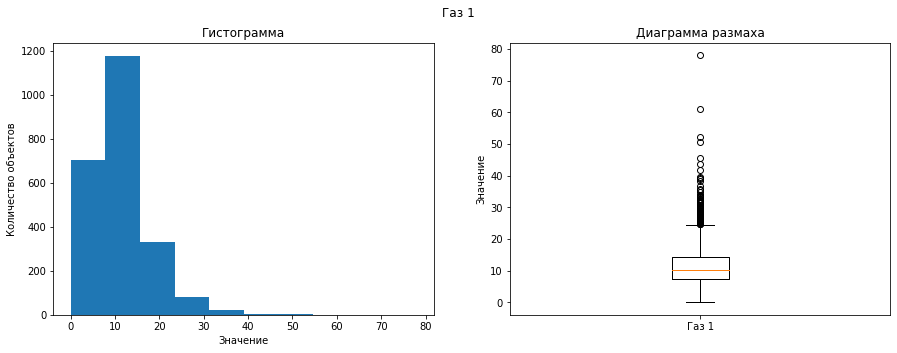

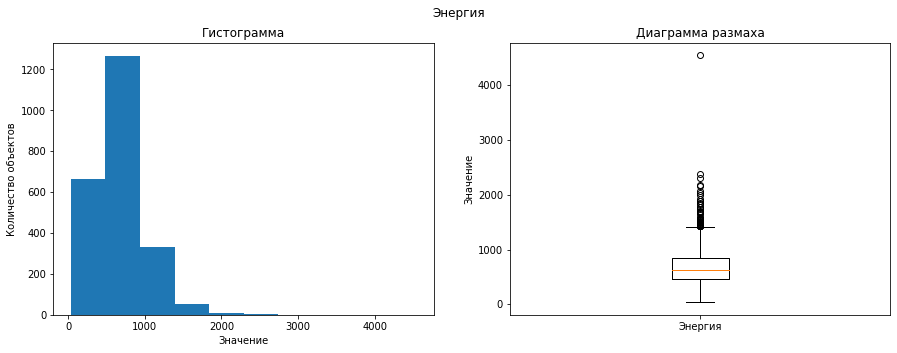

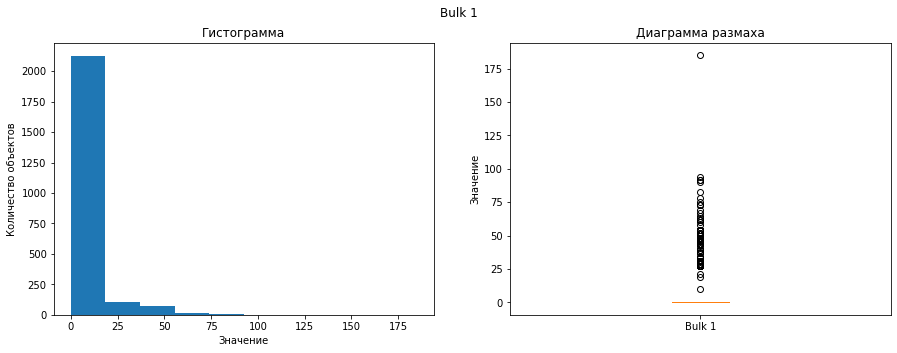

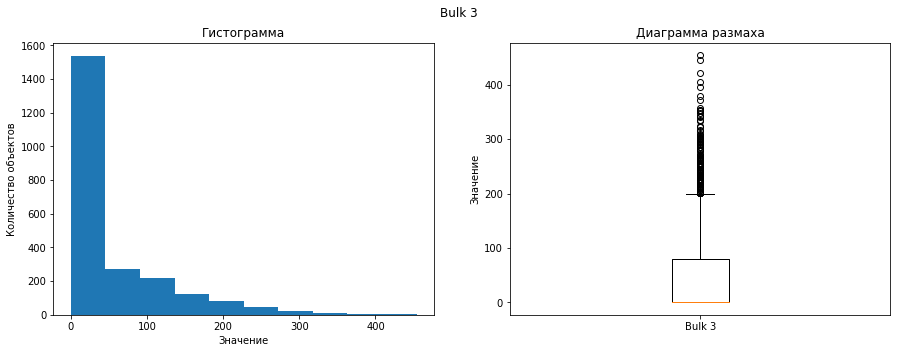

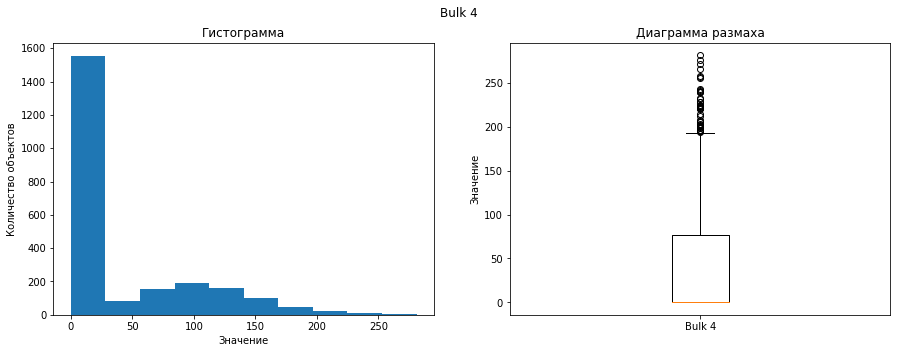

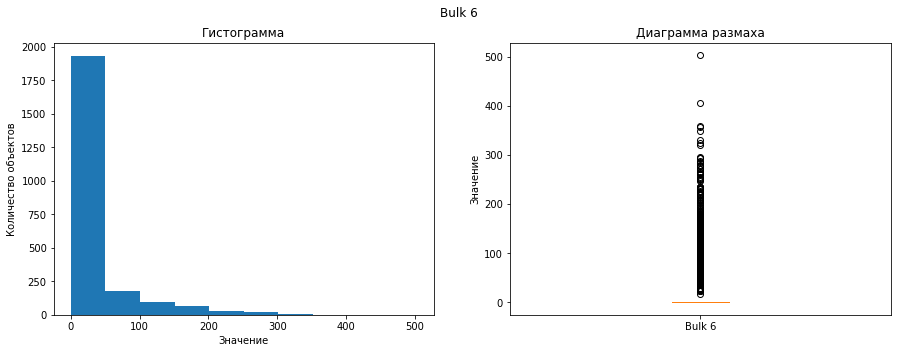

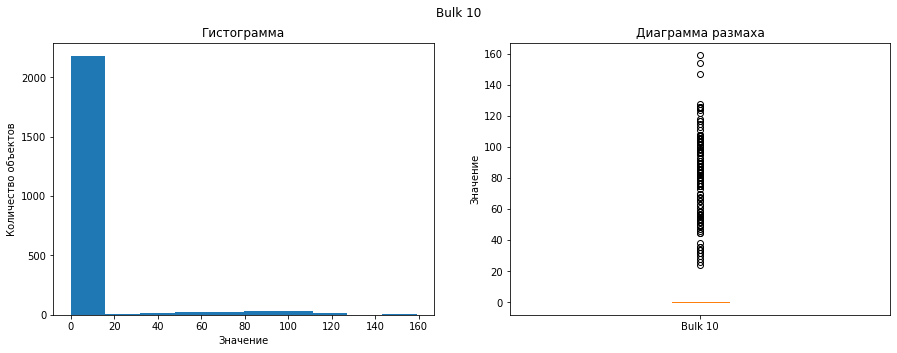

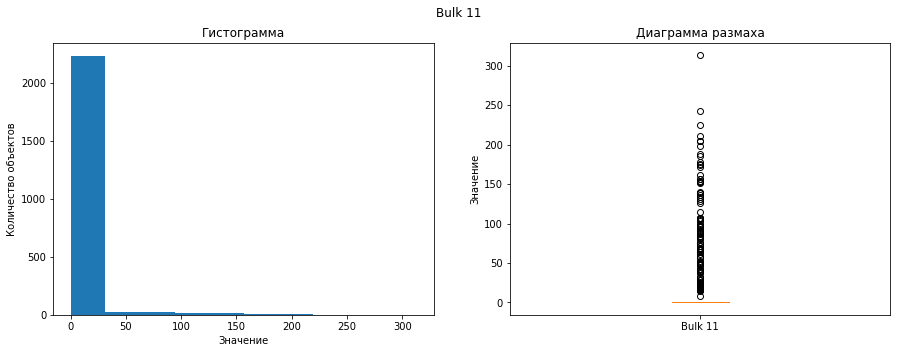

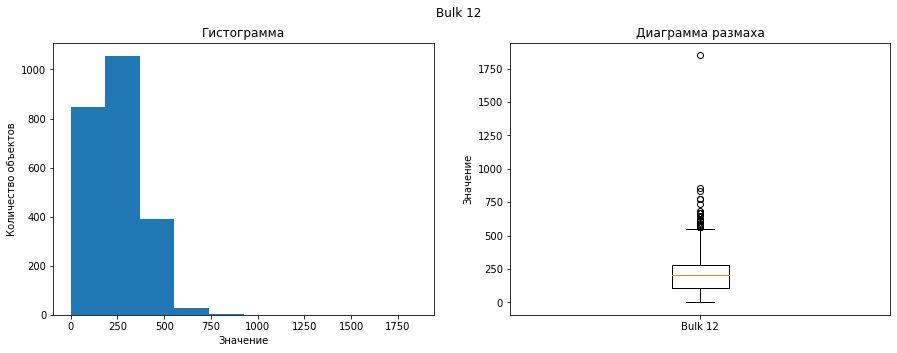

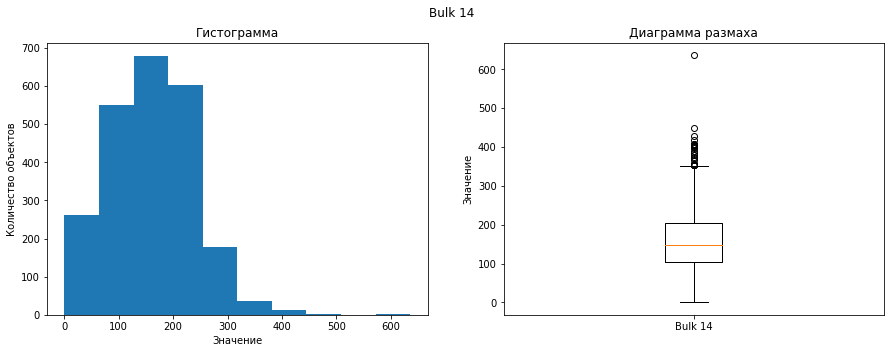

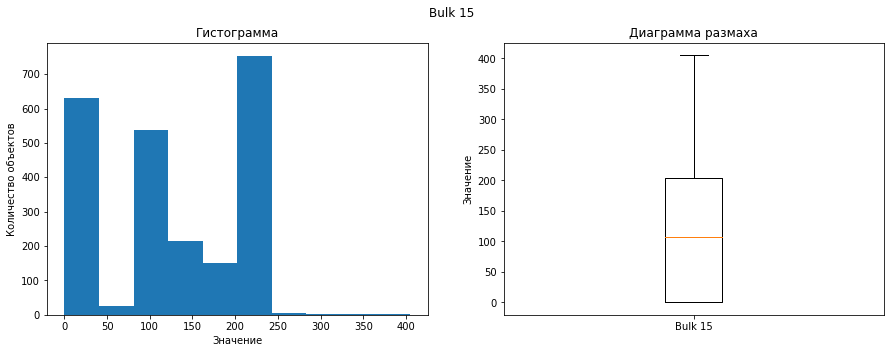

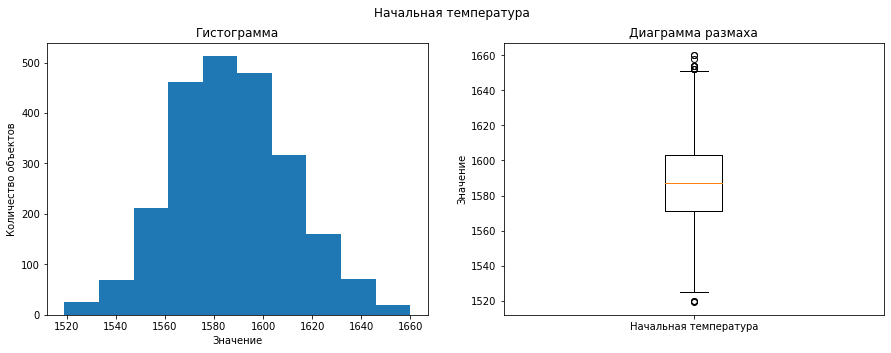

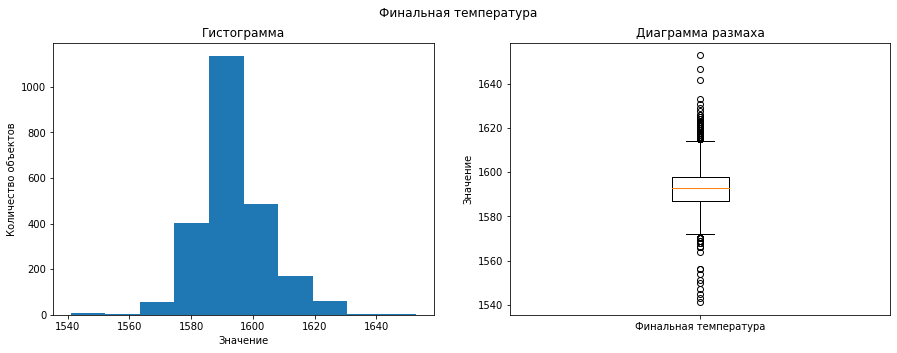

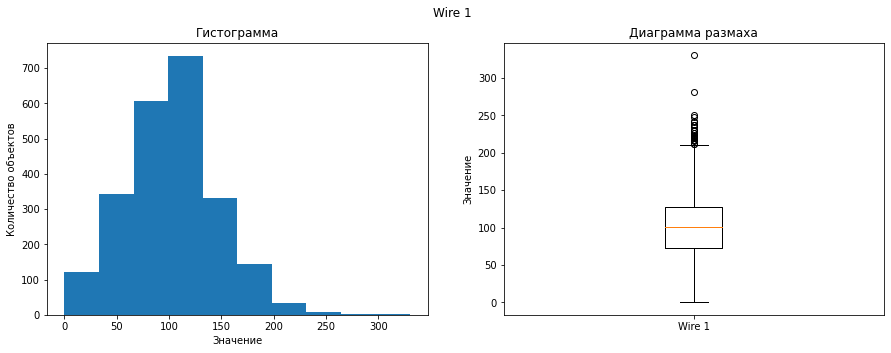

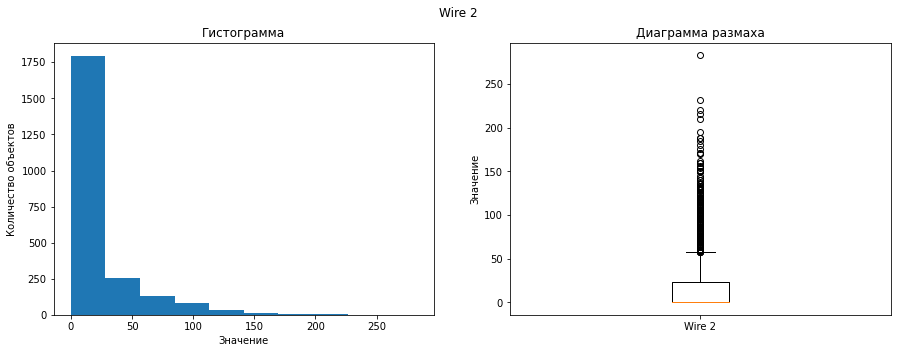




Статистическое описание количественных признаков:


,Газ 1,Энергия,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Начальная температура,Финальная температура,Wire 1,Wire 2
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,11.378854,670.232396,3.435026,47.317126,37.347676,22.419535,5.063683,4.254303,208.597676,153.952668,120.078313,1587.368761,1593.372633,102.423900,17.613213
std,6.397008,319.526707,12.424463,75.238050,58.677890,55.792509,20.938984,22.538843,157.112117,81.410544,84.655967,23.627590,11.207457,43.540975,33.648176
min,0.008399,33.430208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1519.000000,1541.000000,0.000000,0.000000
25%,7.282534,457.924990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,1571.000000,1587.000000,73.204559,0.000000
50%,10.100687,631.228863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,1587.000000,1593.000000,101.103600,0.000000
75%,14.218487,841.824214,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,283.000000,204.000000,204.000000,1603.000000,1598.000000,128.075222,23.102560
max,77.995040,4546.405812,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,1660.000000,1653.000000,330.314424,282.780152





Тепловая карта корреляции между признаками:


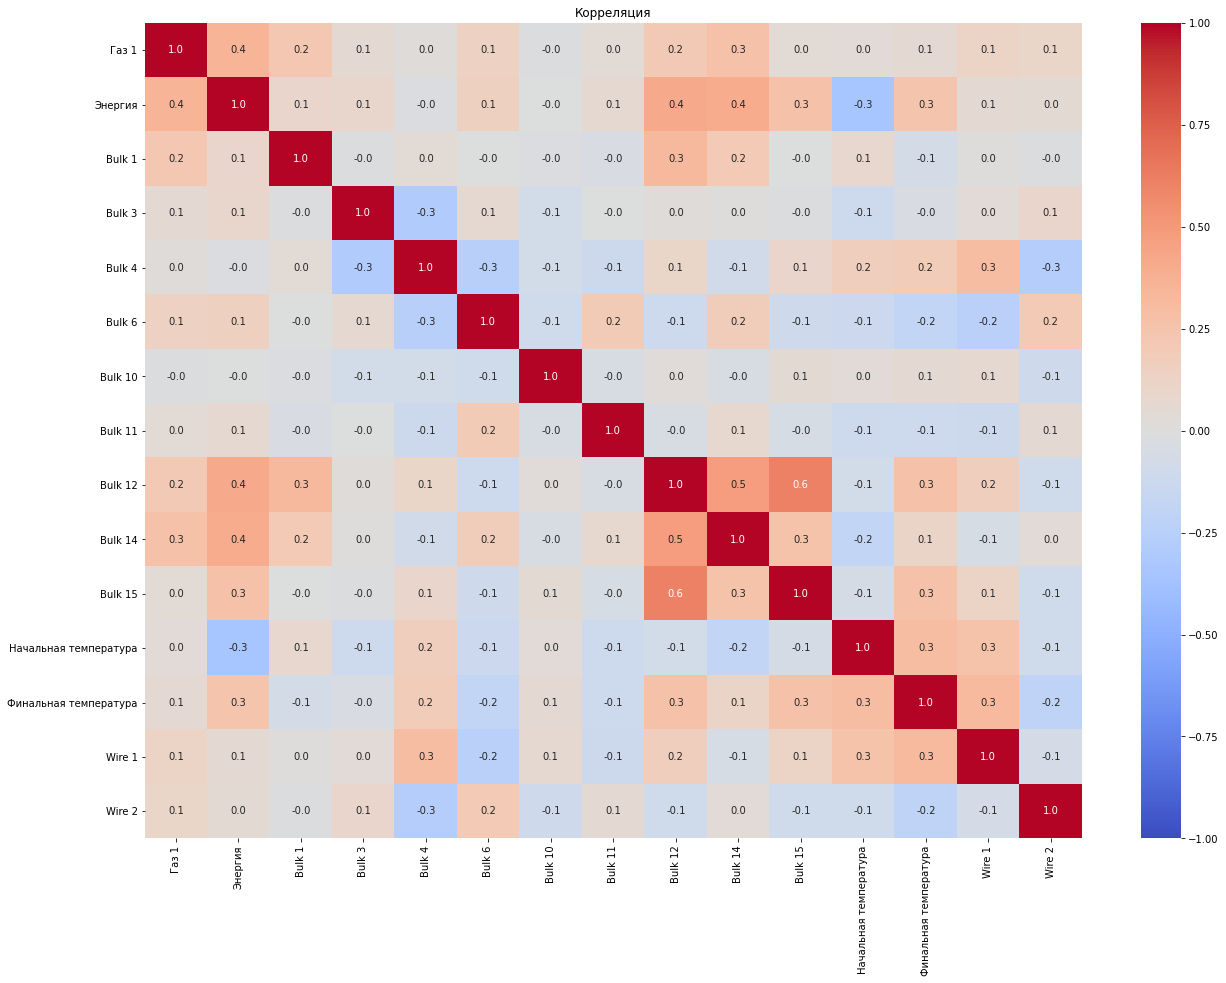

In [32]:
exploring(final_data)

В новых данных нет сильной корреляции ($\geq$ 0.7) между сыпучими материалами, т.к. колонки некоторых материалов, показывающих сильную корреляцию с другими материалами, были удалены из-за неинфрмативности.

### Вывод

В ходе предобработки данных
1. **Была проведена работа с данными**:
     1. Данные об электродах:
           1. _Были удалены партии с выбросами в признаке_ `Реактивная мощность`.
           2. _Был изменен тип_ `object` _на_ `datetime` _для колонок_ `Начало нагрева дугой` _и_ `Конец нагрева дугой`.
           3. _Был сгенерирован признак_ `Энергия`.
           4. _Были удалены все колонки, кроме_ `Key` _и_ `Энергия` _в связи с неинформативностью_.
     2. Данные о подаче сыпучих материалов (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
     3. Результаты измерения температуры:
           1. _Были удалены все колонки, кроме_ `Key` _и_ `Температура`_в связи с неинформативностью_.
           2. _Были удалены партии, содержащие выбросы или значения, не допускаемые бизнесом, а также партии, для которых есть пропуски.
           3. _Были удалены партии с единственным замером температуры_.
           4. _Необходимые данные были выделены в новый датафрейм с колонками_ `Key`,`Начальная температура` _и_ `Финальная температура`.
     4. Данные о проволочных материалах (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
2. **Было проведено внутреннее объединение** (inner_join) вышеперечисленных данных и данных о продувке сплавов по стобцу `key`;  столбец `key` был удалён, так как не является признаком партии.
3. **Было проведено исследование признаков** в нового датафрейма:
     1. Был проведен графический и статистический анализ.
     2. Был проведен анализ корреляции признаков, который показал, что между оставшимися признаками нет сильной корреляции.

## Обучение моделей

### Подготовка признаков

Разделим исходную выборку на признаки и целевой признак, а также на обучающую, валидационную и тестовую выборки.

In [33]:
features = final_data.drop(['Финальная температура'], axis=1)
target = final_data['Финальная температура']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE)

### Обучение моделей

Для обучения выберем следующие модели: LinearRegresson, RandomForestRegressor, CatboostRegressor. С помощью пайплайна подготовим данные так, чтобы они подходили для выбранных моделей, а также подберём оптимальные гиперпараметры и оценим качество моделей с помощью кросс-валидации.

In [34]:
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=RANDOM_STATE),
    CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)    
]

names = [
    'Линейная регрессия',
    'Случайный лес',
    'Градиентный бустинг CatBoost'
]

optimal_models = []

params = [
    {
   
    },
    {
        'randomforestregressor__max_depth': range(1, 10),
        'randomforestregressor__n_estimators': range(10, 211, 50)    
    },
    {
        'catboostregressor__max_depth': range(1, 10),
        'catboostregressor__n_estimators': range(10, 211, 50)
    }   
]


for i in range(len(models)):
    
    pipeline = make_pipeline(
                    StandardScaler(),
                    models[i]
                    )
    
    model = RandomizedSearchCV(
                pipeline, 
                param_distributions=params[i],
                scoring='neg_mean_absolute_error', 
                cv=5,
                random_state=RANDOM_STATE,
                n_jobs=-1
                )
    
    optimal_models.append(model.fit(features_train, target_train))
    model_opt_best_score = optimal_models[i].best_score_ * -1
    model_opt_best_params = optimal_models[i].best_params_



    print()
    print(f"{names[i]}:")
    print(f'\t\tлучшее значение MAE: {model_opt_best_score: .2f}')
    print(f'\t\tлучшие параметры: {model_opt_best_params}')


Линейная регрессия:
		лучшее значение MAE:  6.70
		лучшие параметры: {}

Случайный лес:
		лучшее значение MAE:  6.62
		лучшие параметры: {'randomforestregressor__n_estimators': 210, 'randomforestregressor__max_depth': 8}

Градиентный бустинг CatBoost:
		лучшее значение MAE:  6.60
		лучшие параметры: {'catboostregressor__n_estimators': 110, 'catboostregressor__max_depth': 5}


Лучшее значение MSE достигается моделью **CatBoostRegressor** с гиперпараметрами **n_estimators**=110 и **max_depth**=5. Для дальнейшей работы выберем эту модель.

### Анализ важности признаков

Проанализируем важность признаков для выбранной модели.

In [35]:
preferred_model = optimal_models[2].best_estimator_
feature_importances = preferred_model.named_steps['catboostregressor'].feature_importances_
feature_names = features_train.columns
feature_importances_df = pd.DataFrame({'Признаки':feature_names, 'Важность':feature_importances})
feature_importances_df = feature_importances_df.sort_values('Важность', ascending=True)

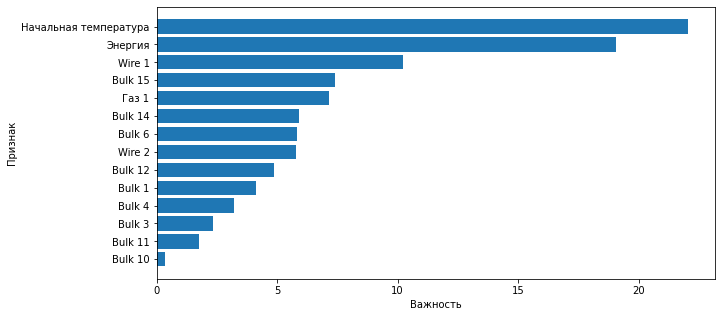

In [36]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.barh(feature_importances_df['Признаки'],
        feature_importances_df['Важность'])
ax.set_ylabel('Признак')
ax.set_xlabel('Важность')
plt.show()

Наиболее важными признаками для рекомендуемой модели являются `Начальная температура`, `Энергия` и `Wire 1`. Наименьшее влияние оказывают признаки `Bulk 10`, `Bulk 11`, `Bulk 3` и `Bulk 4`. 

### Обучение модели на признаках с большой важностью

Обучим модель на признаках с важностью больше 3.

In [37]:
important_features = list(feature_importances_df.loc[feature_importances_df['Важность'] > 3, 'Признаки'])
print(f'Важные признаки: {important_features}')
print(f'Маловажные признаки: {list(set(features_train.columns) - set(important_features))}')

Важные признаки: ['Bulk 4', 'Bulk 1', 'Bulk 12', 'Wire 2', 'Bulk 6', 'Bulk 14', 'Газ 1', 'Bulk 15', 'Wire 1', 'Энергия', 'Начальная температура']
Маловажные признаки: ['Bulk 3', 'Bulk 11', 'Bulk 10']


In [38]:
model_imp_f = RandomizedSearchCV(
                preferred_model, 
                param_distributions=params[2],
                scoring='neg_mean_absolute_error', 
                cv=5,
                random_state=RANDOM_STATE,
                n_jobs=-1
                )

final_model = model_imp_f.fit(features_train[important_features], target_train)    
final_model_best_score = final_model.best_score_ * -1
final_model_best_params = final_model.best_params_
print()
print(f"{names[2]}:")
print(f'\t\tлучшее значение MAE: {final_model_best_score: .2f}')
print(f'\t\tлучшие параметры: {final_model_best_params}')


Градиентный бустинг CatBoost:
		лучшее значение MAE:  6.55
		лучшие параметры: {'catboostregressor__n_estimators': 210, 'catboostregressor__max_depth': 6}


Удалось улучшить MAE. Для рекомендации выберем модель **CatBoostRegressor** с гиперпараметрами **n_estimators**=210 и **max_depth**=6. 

### Вывод

В ходе обучение моделей
1. **Были подготовлены признаки**: 
    1. Данные были разделены на признаки и целевой признак.
    2. Признаки были разбиты на обучающую и тестовую выборки.
2. **Были обучены модели**:
    1. Для обучения были выбраны модели LinearRegression, RandomForestRegressor и CatBoostRegressor.
    2. Для моделей были созданы пайплайны.
    3. Были найдены оптимальные гиперпараметры для моделей с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE.
    4. Для дальнейшней работы была выбрана модель CatBoostRegressor с гиперпараметрами n_estimators=110 и max_depth=5.
4. **Был проведён анализ важности признаков** для выбраной модели:
    1. Набиолее важными признаками оказались `Начальная температура`, `Энергия` и `Wire 1`.
    2. Наименее важными признаками оказались `Bulk 10`, `Bulk 11`, `Bulk 13`и `Bulk 4`.
5. **Было проведено обучение модели на важных признаках**:
    1. Для обучения были выбраны признаки с важностью больше 3. 
    2. Были найдены оптимальные гиперпараметры для модели с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE. 
    3. Рекомендуемой стала модель **CatBoostRegressor** с гиперпараметрами **n_estimators**=210 и **max_depth**=6, обученная на признаках с важностью больше 3.

## Тестирование рекомендуемой модели

### Оценка качества на тестовой выборке

Выберем важные признаки.

In [39]:
features_test = features_test[important_features]

Метрикой для финального тестирования выступит MAE в связи с легкой интерпертируемостью. Значение MAE не должно превысить 6.8.

In [40]:
predict = final_model.predict(features_test)    
score = mean_absolute_error(predict, target_test)
    
print(f'Значение MAE на тестовой выборке: {score:.2f}')

Значение MAE на тестовой выборке: 6.61


Значение MAE удовлетворяет поставленной задаче.

### Проверка на адекватность

Проверим модель на адекватность посредством сравнения с константной моделью, которая всегда возвращает среднее значение.

In [41]:
dummy = DummyRegressor()

dummy_pipeline = make_pipeline(
                 StandardScaler(),
                 dummy
                 )

dummy_pipeline.fit(features_train[important_features], target_train)
predict = dummy_pipeline.predict(features_test)

score = mean_absolute_error(predict, target_test)

print(f'Качество dummy-модели на тествой выборке: {score:.2f}' )

Качество dummy-модели на тествой выборке: 8.05


Константная модель предсказывает темературу на 20% хуже, чем рекомендуемая. Это значителная разница, поэтому выбранная модель адекватна.

### Вывод

В ходе этапа тестирования рекомендуемой модели
1. **Качество модели было проверено на тестовой выборке**; модель удовлетворяет поставленной задаче (MAE < 6.8).
2. **Модель была проверена на адекватность**:
    1. Была обучена константная модель, возвращающая среднее значение. 
    2. Было выяснено, что константная модель предсказывает температуру на 20% хуже рекомендуемой, что подтверждает адекватность выбранной модели.

## Общий вывод

<font size='5'> На этапе исследовательского анализа были рассмотрены все наборы данных.</font>


**Результаты анализа данных об электродах:**
1. в данных нет пропусков;
2. стобцы `Начало нагрева дугой` и `Конец нагрева дугой` содержат записи о времени, но представлены типом `object`; тип лучше заменить на `datetime` для удобства работы;
3. согласно графикам и статистическому описанию столбец `Реактивная мощность` имеет выбросы: есть значения около -700 при том, что значение мощности должно быть неотрицательным; партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
4. имеются аномально высокие значения, допускаемые бизнесом;
5. между `Активной` и `Реактивной мощность` обнаружена корреляция, близкая к 1;
6. на основе данных об электродах можно рассчиать суммарную затраченную энергию для каждой партии: $E = \sum\limits_{i=1}^n t_i P_i$, где $n$ - число нагревов партии, $P_i$ - полная мощность дла нагрева $i$, рассчитаная по формуле $P_i = \sqrt{P_{act \ i}^2 + P_{react \ i}^2}$, а $t_i$ рассчитывается как разница между началом и концом нагрева; сгенерированный признак будет использован для разработки модели

**Результаты анализа данных о подаче сыпучих материалов (объем):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный сыпучий материал - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

**Результаты анализа данных о подаче сыпучих материалов (время):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

**Результаты анализа данных о продувке сплава газом:**
1. в данных нет пропусков; 
2. в признаках не обнаружено выбросов; присутствуют аномально высокие значения, допускаемые бизнесом.

**Результаты анализа данных об измерениях температуры:**
1. в данных много пропусков; можно поставить под сомнение адекватность замеров температуры для партий, в строках которых есть пропуски - такие партии лучше исключить из рассмотрения;  
2. в признаке `Температура` есть выбросы: некоторые значения меньше нижней грани температуры плавления стали (1300); партии, для которых записано ошибочное значение, необходимо будет убрать из рассмотрения;
3. имеются как аномально высокие и аномально низкие значения, допускаемые бизнесом, так и аномально низкие значения, которые не допускаются (ниже 1450);
4. бизнес допускает использования в качестве признака первый замер температуры для партии; 
5. целевым признаком для модели является последний замер температуры в партии;
6. партии с единственным замером следует исключить из рассмотрения, иначе произойдёт утечка данных;
7. первый и последний замеры температуры в качестве разных признаков необходимо выделить в отдельный датафрейм.

**Результаты анализа данных о проволочных материалах (объем):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки партии не был добавлен данный вид проволоки - NaN можно заменить на 0;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме, поэтому они будут малоинформативны - их можно удалить;
3. в признаках не обнаружено выбросов; присутствуют аномально высокие или низкие значения, допускаемые бизнесом;
4. между некоторыми признаками обнаружена сильная положительная корреляция (>= 0.7); в будущем для линейных моделей необходимо будет из пары коррелирующих признаков выбирать только один для последующего включения в данные для проектирования модели.

**Результаты анализа данных о проволочных материалах (время):**
1. в данных множество пропусков; в данном случае NaN говрит о том, что в ходе обработки данной партии не был добавлен данный сыпучий материал;
2. в некоторых колонках количество информативных записей меньше 5% от количества записей в датафрейме;
3. с точки зрения информативности признаков данные не представляют интереса, поэтому они не будут использоваться на этапе построения модели.

<font size='5'> На основании разведывательного анализа данных был разработан план последующей работы. </font>

<font size='5'><br></font>

<font size='5'> Была проведена предобработка данных. </font>
1. **Была проведена работа с данными**:
     1. Данные об электродах:
           1. _Были удалены партии с выбросами в признаке_ `Реактивная мощность`.
           2. _Был изменен тип_ `object` _на_ `datetime` _для колонок_ `Начало нагрева дугой` _и_ `Конец нагрева дугой`.
           3. _Был сгенерирован признак_ `Энергия`.
           4. _Были удалены все колонки, кроме_ `Key` _и_ `Энергия` _в связи с неинформативностью_.
     2. Данные о подаче сыпучих материалов (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
     3. Результаты измерения температуры:
           1. _Были удалены все колонки, кроме_ `Key` _и_ `Температура`_в связи с неинформативностью_.
           2. _Были удалены партии, содержащие выбросы или значения, не допускаемые бизнесом, а также партии, для которых есть пропуски_.
           3. _Были удалены партии с единственным замером температуры_.
           4. _Необходимые данные были выделены в новый датафрейм с колонками_ `Key`,`Начальная температура` _и_ `Финальная температура`.
     4. Данные о проволочных материалах (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
2. **Было проведено внутреннее объединение** (inner_join) вышеперечисленных данных и данных о продувке сплавов по стобцу `key`;  столбец `key` был удалён, так как не является признаком партии.
3. **Было проведено исследование признаков** в нового датафрейма:
     1. Был проведен графический и статистический анализ.
     2. Был проведен анализ корреляции признаков, который показал, что между оставшимися признаками нет сильной корреляции.
     
<font size='5'> Были обучены и проанализированы модели.</font>
1. **Были подготовлены признаки**: 
    1. Данные были разделены на признаки и целевой признак.
    2. Признаки были разбиты на обучающую и тестовую выборки.
2. **Были обучены модели**:
    1. Для обучения были выбраны модели LinearRegression, RandomForestRegressor и CatBoostRegressor.
    2. Для моделей были созданы пайплайны.
    3. Были найдены оптимальные гиперпараметры для моделей с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE.
    4. Для дальнейшней работы была выбрана модель CatBoostRegressor с гиперпараметрами n_estimators=110 и max_depth=5.
4. **Был проведён анализ важности признаков** для выбраной модели:
    1. Набиолее важными признаками оказались `Начальная температура`, `Энергия` и `Wire 1`.
    2. Наименее важными признаками оказались `Bulk 10`, `Bulk 11`, `Bulk 13`и `Bulk 4`.
5. **Было проведено обучение модели на важных признаках**:
    1. Для обучения были выбраны признаки с важностью больше 3. 
    2. Были найдены оптимальные гиперпараметры для модели с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE. 
    3. Рекомендуемой стала модель **CatBoostRegressor** с гиперпараметрами **n_estimators**=210 и **max_depth**=6, обученная на признаках с важностью больше 3.
    
<font size='5'> Было проведено тестирование рекомендуемой модели.</font>
1. **Качество модели было проверено на тестовой выборке**; модель удовлетворяет поставленной задаче (MAE < 6.8).
2. **Модель была проверена на адекватность**:
    1. Была обучена константная модель, возвращающая среднее значение. 
    2. Было выяснено, что константная модель предсказывает температуру на 20% хуже рекомендуемой, что подтверждает адекватность выбранной модели.

## Отчет

### Сравнение плана работы и проделанной работы

#### План работы

1. **Предобработка данных**:
    1. Работа с данными:
        1. _Данные об электродах_:
            1. _Уаление партий с выбросами в признаке_ `Реактивная мощность`.
            2. _Замена типа_ `object` _на_ `datetime` _для колонок_ `Начало нагрева дугой` _и_ `Конец нагрева дугой`.
            3. _Генерация признака_ `Энергия` _с помощью агрегирования и рассчётов по имеющимся признакам_.
            4. _Удаление всех колонок, кроме_ `Key` _и_ `Энергия` _в связи с неинформативностью_.
        2. _Данные о подаче сыпучих материалов (объем)_:
            1. _Удаление неинформативных колонок_.
            2. _Заполнение пропусков нулями_.
        3. _Результаты измерения температуры_:
            1. _Удаление всех колонок, кроме_ `Key` _и_ `Температура`_в связи с неинформативностью_.
            2. _Удаление партий, для которых есть пропуски_.
            3. _Удаление партий с выбросами в признаке_ `Температура`.
            4. _Удаление партий с единственным замером температуры_.
            5. _Выделение данных в новый датафрейм с колонками_ `Key`,`Начальная температура` _и_ `Финальная температура`.
        2. _Данные о проволочных материалах (объем)_:
            1. _Удаление неинформативных колонок_.
            2. _Заполнение пропусков нулями_.
    2. Внутреннее объединение (inner_join) вышеперечисленных данных и данных о продувке сплавов по стобцу `Key`; удаление столбца `Key` в связи с неинформативностью.
    3. Исследование признаков в нового датафрейма:
        1. Графический и статистический анализ.
        2. Анализ корреляции признаков.
    4. Написание вывода по этапу.
2. **Обучение моделей**:
    1. Подготовка признаков: 
        1. _Разделение данных на признаки и целевой признак_.
        2. _Разбиение признаков на обучающую и тестовую выборки_.
    2. Выбор моделей (предположительно LinearRegression, RandomForestRegressor и CatBoostRegressor).
    3. Формирование пайплайна:
        1. _Создание обработчиков и селекторов колонок_.
        2. _Создание пайплайнов из обработчиков, селекторов и моделей_.
        3. _Поиск оптимальных параметров и лучших моделей с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE_.
    4. Выбор лучшей модели для рекомендации.
    5. Анализ важности признаков для рекомендуемой модели.
    5. Написание вывода по этапу.
3. **Тестирование рекомендуемой модели**:
    1. Оценка качества на тестовой выборке с помощью метрики MAE.
    2. Проверка модели на адекватность: сравнение с константной моделью.
    3. Написание вывода по этапу.
4. **Написание общего вывода о проделанной работе**.

#### Проделанная работа

<font size='5'> Была проведена предобработка данных. </font>
1. **Была проведена работа с данными**:
     1. Данные об электродах:
           1. _Были удалены партии с выбросами в признаке_ `Реактивная мощность`.
           2. _Был изменен тип_ `object` _на_ `datetime` _для колонок_ `Начало нагрева дугой` _и_ `Конец нагрева дугой`.
           3. _Был сгенерирован признак_ `Энергия`.
           4. _Были удалены все колонки, кроме_ `Key` _и_ `Энергия` _в связи с неинформативностью_.
     2. Данные о подаче сыпучих материалов (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
     3. Результаты измерения температуры:
           1. _Были удалены все колонки, кроме_ `Key` _и_ `Температура`_в связи с неинформативностью_.
           2. _Были удалены партии, содержащие выбросы или значения, не допускаемые бизнесом, а также партии, для которых есть пропуски_.
           3. _Были удалены партии с единственным замером температуры_.
           4. _Необходимые данные были выделены в новый датафрейм с колонками_ `Key`,`Начальная температура` _и_ `Финальная температура`.
     4. Данные о проволочных материалах (объем):
           1. _Были удалены неинформативные колонки_.
           2. _Пропуски были заполнены нулями_.
2. **Было проведено внутреннее объединение** (inner_join) вышеперечисленных данных и данных о продувке сплавов по стобцу `key`;  столбец `key` был удалён, так как не является признаком партии.
3. **Было проведено исследование признаков** в нового датафрейма:
     1. Был проведен графический и статистический анализ.
     2. Был проведен анализ корреляции признаков, который показал, что между оставшимися признаками нет сильной корреляции.
     
<font size='5'> Были обучены и проанализированы модели.</font>
1. **Были подготовлены признаки**: 
    1. Данные были разделены на признаки и целевой признак.
    2. Признаки были разбиты на обучающую и тестовую выборки.
2. **Были обучены модели**:
    1. Для обучения были выбраны модели LinearRegression, RandomForestRegressor и CatBoostRegressor.
    2. Для моделей были созданы пайплайны.
    3. Были найдены оптимальные гиперпараметры для моделей с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE.
    4. Для дальнейшней работы была выбрана модель CatBoostRegressor с гиперпараметрами n_estimators=110 и max_depth=5.
4. **Был проведён анализ важности признаков** для выбраной модели:
    1. Набиолее важными признаками оказались `Начальная температура`, `Энергия` и `Wire 1`.
    2. Наименее важными признаками оказались `Bulk 10`, `Bulk 11`, `Bulk 13`и `Bulk 4`.
5. **Было проведено обучение модели на важных признаках**:
    1. Для обучения были выбраны признаки с важностью больше 3. 
    2. Были найдены оптимальные гиперпараметры для модели с помощью RandomizedSearchCV с контролем качества кросс-валидацией и метрикой MAE. 
    3. Рекомендуемой стала модель **CatBoostRegressor** с гиперпараметрами **n_estimators**=210 и **max_depth**=6, обученная на признаках с важностью больше 3.
    
<font size='5'> Было проведено тестирование рекомендуемой модели.</font>
1. **Качество модели было проверено на тестовой выборке**; модель удовлетворяет поставленной задаче (MAE < 6.8).
2. **Модель была проверена на адекватность**:
    1. Была обучена константная модель, возвращающая среднее значение. 
    2. Было выяснено, что константная модель предсказывает температуру на 20% хуже рекомендуемой, что подтверждает адекватность выбранной модели.

#### Сравнение

Проделанная работа соответствует плану, исключая два момента:
1. Написание собственных обработчиков колонок и селекторов не потребовалось, так как все признаки были одного типа и для их обработки было достаточно методов sklearn.
2. В этап обучения моделей было добавлено обучение выбранной модели на важных признаков, т.к. это позволило добиться улучшения качества модели.

### Описание трудностей проекта

Основной труднотью проекта была формализация задачи по описанию: было необходимо разобраться в процессе изготовления стали, чтобы получить представление о том, как правильно работать с данными и как их предобрабатывать.

### Ключевые шаги проекта


1. **Исследовательский анализ данных:**
   1. Вывод основной информации о полученных датафреймах.
   2. Вывод первых строк датафреймов.
   3. Построение гистограмм и диаграмм размаха для всех количественных признаков датафрейма.
   4. Вывод статистического описания для всех количесвтенных признаков.
   5. Вывод тепловой карты корреляции для количесвтенных признаков.
   6. Написание примерного плана последующей предобработки данного датафрейма.

2. **Построение плана последующей работы.**

3. **Предобработка данных:**
    1. Предобработка исходных данных:
       1. _Данных об электродах_.
       2. _Данных о подаче сыпучих материалов (объем)_.
       3. _Результатов измерения температуры_.
       4. _Данных о проволочных материалах (объем)_.
   2. Внутреннее объединение вышеперечисленных данных и данных о продувке сплавов по стобцу `key`.
   3. Исследование признаков нового датафрейма:
     
4. **Обучение и анализ моделей:**
   1. Подготовка признаков. 
   2. Обучение моделей и выбор модели для последующей работы.
   4. Анализ важности признаков для выбраной модели.
   5. Обучение модели на важных признаках и выбор рекомендуемой модели.
    
5. **Тестирование рекомендуемой модели:**
   1. Проверка качества модели на тестовой выборке.
   2. Модель была проверена на адекватность.

### Признаки, которые использовали для обучения и их предобработка

|№|Признак|Предобработка|Остался ли в важных|
|-|-|-|-|
|1|Начальная температура|удаление выбросов и значений, не допускаемых бизнесом; удаление партий, для которых нашлись пропуски; удаление партий, для которых была только одна итерация; значения были получены из общих данных о замерах температуры посредством выбора замера для первой итерации партии|+|
|2|Энергия|был сгенерирован на основе признаков `Активная мощность`, `Реактивная мощность`, `Начало нагрева дугой` и `Конец нагрева дугой`|+|
|3|Газ 1|-|+|
|4|Bulk 1|Заполнение пропусков нулями|+|
|5|Bulk 3|Заполнение пропусков нулями|-|
|6|Bulk 4|Заполнение пропусков нулями|+|
|7|Bulk 6|Заполнение пропусков нулями|+|
|8|Bulk 10|Заполнение пропусков нулями|-|
|9|Bulk 11|Заполнение пропусков нулями|-|
|10|Bulk 12|Заполнение пропусков нулями|+|
|11|Bulk 14|Заполнение пропусков нулями|+|
|12|Bulk 15|Заполнение пропусков нулями|+|
|13|Wire 1|Заполнение пропусков нулями|+|
|14|Wire 2|Заполнение пропусков нулями|+|
|15|Финальная температура (целевой)|удаление выбросов и значений, не допускаемых бизнесом; удаление партий, для которых нашлись пропуски; удаление партий, для которых была только одна итерация; значения были получены из общих данных о замерах температуры посредством выбора замера для последней итерации партии|- (т.к. целевой)|

### Описание рекомендуемой модели

Рекомендуемой стала модель **CatBoostRegressor** с гиперпараметрами
- **n_estimators** = 210,
- **max_depth** = 6,
- **random_state** = 80523,
обученная на важных признаках.

### Итоговая метрика

На этапе тестирования рекомендуемой модели удалось добиться значения итоговой метрики MAE, равного 6.61.

### Рекомендации по улучшению решения

Важные для модели признаки были найдены вручную. Решение можено улучить, добавив астоматизированный отбор важных для модели признаков.